# 0. Import libraries and load Data

We install required Python packages using pip package manager.

In [1]:
!pip install pandas -q          # pandas: provides data manipulation and analysis tools
!pip install numpy -q           # numpy: provides support for numerical operations
!pip install matplotlib -q      # matplotlib: provides data visualization tools
!pip install seaborn -q         # seaborn: provides advanced data visualization tools
!pip install scikit-learn -q    # scikit-learn: provides machine learning algorithms
!pip install scipy -q           # scipy: provides scientific computing functions

We import required Python libraries.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
import math
import seaborn as sns
from matplotlib import colors

from sklearn.impute import KNNImputer

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.model_selection import GridSearchCV

We read the 'csv' files and store the data in DataFrames.

In [3]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
poi_df = pd.read_csv('data/poi.csv')

/tmp/ipykernel_9617/4245473066.py:3: DtypeWarning: Columns (7,9,11,13,17,18,19,22,23,24,25,26,28,29,30,32,33,34,35,36,37,38,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,74,77,80,82,83,84,85,86,87,90,91,92,95) have mixed types. Specify dtype option on import or set low_memory=False.
  poi_df = pd.read_csv('data/poi.csv')


# 1. Data Preparing

# 1.0. Utilities Functions

We create this function which carries out 2 analysis on the NaNs of our dataset. 

In [4]:
def NaN_analysis(df):
    """
    Computes two types of analyses on the input pandas DataFrame:
    
    1. Percentage of NaN values in each column, sorted in descending order of percentage.
    2. Number of rows with a specific number of NaN values, up to the total number of columns in the input DataFrame.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The DataFrame to be analyzed.
    
    Returns:
    --------
    analysis1 : pandas DataFrame
        The percentage of NaN values in each column, sorted in descending order of percentage.
    analysis2 : pandas DataFrame
        The number of rows with a specific number of NaN values, up to the total number of columns in the input DataFrame.
    """
    # analysis1: percentage of NaN values in columns
    d = {'column': [], 'n_nan': [], 'percentage': []}
    for col in df.columns:
        n_nan = df[(df[col].isna())].shape[0]
        d['column'].append(col)
        d['n_nan'].append(n_nan)
        d['percentage'].append((n_nan*100)/df.shape[0])
    analysis1 = pd.DataFrame(d).sort_values('percentage', ascending=False).reset_index(drop=True)
    # analysis2: number of NaN values in each row grouped by number of NaN values
    analysis2 = df.isna().sum(axis=1)
    analysis2 = analysis2.value_counts().to_frame().reset_index().sort_values('index', ascending=False).reset_index(drop=True).rename(columns={'index': 'n_nan', 'count': 'n_rows'})
    return analysis1, analysis2

We write also this other function which performs a groupby operation on a column of the dataset and returns the percentage of each value in the considered feature. 

In [5]:
def groupby_count_percentage(df, col):
    tmp = df[col].to_frame().copy()
    tmp.fillna('NaN', inplace=True)
    tmp['count'] = 0
    tmp = tmp.groupby(col).count().reset_index().sort_values('count', ascending=False).reset_index(drop=True)
    tmp['percentage'] = (tmp['count']*100)/df.shape[0]
    return tmp

Finally we also code this function which is used to plot useful graphs about the distribution ou the features. In particular it plots histograms and 2D histogrms which are useful to show the distribution of the feature across the indices of the dataset.

In [6]:
def hist_subplot(df, feature, b=100):
    df = df.dropna(subset=[feature]).reset_index(drop=True) #before plotting we remove the NaNs otherwise it will not be possible to plot the graphs 
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    axs[0].hist(df[feature], bins=b)
    axs[0].set_title('Histogram distribution of {}'.format(feature))
    axs[0].set_ylabel('Count')
    axs[0].set_xlabel('Value')
    axs[1].hist2d(pd.Series(np.array([i for i in range(df.loc[:, feature].shape[0])])), df.loc[:, feature], bins=b, norm=colors.LogNorm())
    axs[1].set_title('2D histogram distribution of {}'.format(feature))
    axs[1].set_ylabel('Value')
    axs[1].set_xlabel('Index')
    plt.tight_layout()
    plt.show()
    return

# 1.1. Point of Interest Analysis

We will now have a look at what kind of information the point of interest file contians. 

In [7]:
poi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397382 entries, 0 to 397381
Data columns (total 96 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id_on_platform         397382 non-null  int64  
 1   lat                    397382 non-null  float64
 2   lon                    397382 non-null  float64
 3   source                 397382 non-null  object 
 4   tags.addr:city         80929 non-null   object 
 5   tags.addr:country      32852 non-null   object 
 6   tags.addr:housenumber  104548 non-null  object 
 7   tags.addr:postcode     64669 non-null   object 
 8   tags.addr:street       97486 non-null   object 
 9   tags.alt_name:gl       1 non-null       object 
 10  tags.amenity           50459 non-null   object 
 11  tags.artwork_type      662 non-null     object 
 12  tags.barrier           42890 non-null   object 
 13  tags.bicycle           3878 non-null    object 
 14  tags.brand             4342 non-null

We perform the NaN analysis on the poi_df. 

In [8]:
analysis1, analysis2 = NaN_analysis(poi_df)

In [9]:
analysis1

,column,n_nan,percentage
0,tags.alt_name:gl,397381,99.999748
1,tags.source:name:oc,397381,99.999748
2,tags.name:east2276,397381,99.999748
3,tags.name:za,397381,99.999748
4,tags.ref:ISTAT,397380,99.999497
...,...,...,...
91,tags.addr:housenumber,292834,73.690806
92,lon,0,0.000000
93,source,0,0.000000
94,lat,0,0.000000


In [10]:
analysis2

,n_nan,n_rows
0,92,106013
1,91,102752
2,90,66381
3,89,26608
4,88,40318
5,87,37835
6,86,9904
7,85,4386
8,84,1632
9,83,830


By running the NaN analysis we notice that almost all the columns contains over 90% of NaNs, so the only columns that we can use for the creations of a new feature are lat and lon.

In [11]:
poi_df = poi_df.filter(['lat', 'lon'])

By plotting the scatterplot of the coordinates we can see the distribution of the points of interest, which are concentrated in 4 main locations. 

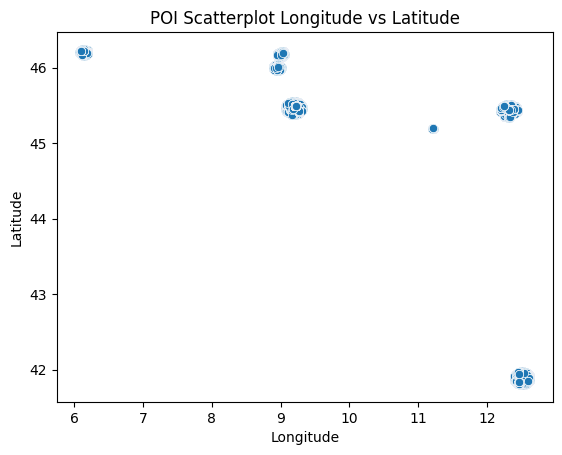

In [12]:
sns.scatterplot(x='lon', y='lat', data=poi_df)
plt.title('POI Scatterplot Longitude vs Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

# 1.2. Train Dataset Analysis

We drop the id column from train_df, in order to leave in train_df only the columns of the features and the column of the predictions, which are the only ones we have to analyze.

In [13]:
# drop id
train_df.drop('id', axis=1, inplace=True)

We perform the NaN analysis on train_df.

In [14]:
analysis1, analysis2 = NaN_analysis(train_df)

In [15]:
analysis1

,column,n_nan,percentage
0,garden,31529,68.079547
1,energy_efficiency,19903,42.975903
2,total_floors,18349,39.620401
3,elevator,17443,37.664104
4,expenses,16154,34.880808
5,balcony,15443,33.345569
6,construction_year,13946,30.113146
7,n_bathrooms,2416,5.216790
8,floor,2031,4.385472
9,conditions,1229,2.653740


In [16]:
analysis2

,n_nan,n_rows
0,12,1
1,11,3
2,10,172
3,9,147
4,8,536
5,7,1295
6,6,3230
7,5,5605
8,4,6704
9,3,7330


# 1.3. Add Features

We add to the dataframe the new feature 'n_poi'. 

In [17]:
def get_n_poi(lat, lon, poi_df, radius=0.001):
    if math.isnan(lat) or math.isnan(lon):
        return np.nan # check whether lat or lon is NaN using the math.isnan() function. If either of them is NaN, the function returns NaN
    # get all poi in a certain radius from the given lat and lon
    series = poi_df[(poi_df['lat']-lat)**2 + (poi_df['lon']-lon)**2 <= radius**2]
    # n_poi = np.nan if series.shape[0] == 0 else series.shape[0]
    return series.shape[0] # n_poi

In [18]:
train_df['n_poi'] = train_df.apply(lambda x: get_n_poi(x['latitude'], x['longitude'], poi_df), axis=1)

We add the feature ratio which is the ratio between the number of rooms and bathrooms in each house. 

In [19]:
def lambda_ratio(x):
    n_room = x['n_rooms']
    n_bathroom = x['n_bathrooms']
    if not math.isnan(n_room) and not math.isnan(n_bathroom): # check if both n_room and n_bathroom are valid numbers (i.e., not NaN)
        return n_room/max(1, n_bathroom) #calculate the ratio between the number of rooms and the maximum of 1 and the number of bathrooms (the denominator can not be zero)
    else:
        return np.nan

In [20]:
train_df['ratio'] = train_df.apply(lambda x: lambda_ratio(x), axis=1)

We add the feature m2_per_bathrooms. 
The feature is the surface of the house per bathroom, which has been calculated by dividing the surface of the house by all the living spaces with as unitary measure the extention of a bathroom (with the assumption that a room as a surface 3 times bigger than the surface of a bathroom). 

In [21]:
def lambda_m2_per_bathrooms(x):
    n_room = x['n_rooms']
    n_bathroom = x['n_bathrooms']
    m2 = x['surface']
    if not math.isnan(n_bathroom) and not math.isnan(m2):
        return m2/max(1, n_room*3 + n_bathroom) #the raatio is calculated using the max function at the denominator to avoid to divide by 0, which is not possible
    else:
        return np.nan

In [22]:
train_df['m2_per_bathrooms'] = train_df.apply(lambda x: lambda_m2_per_bathrooms(x), axis=1)

We show the train_df following after the addition of the new features.

In [23]:
train_df

,price,balcony,conditions,construction_year,latitude,longitude,energy_efficiency,expenses,floor,garden,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface,n_poi,ratio,m2_per_bathrooms
0,60000,True,Buono stato / Abitabile,1980.0,41.901300,12.700000,175.00,30.0,2.0,NaN,1.0,NaN,3.0,1.0,1.00000,35.0,0.0,1.0,8.750000
1,900000,NaN,Buono stato / Abitabile,NaN,41.907017,12.481311,NaN,NaN,3.0,NaN,1.0,1.0,NaN,3.0,1.00000,131.0,25.0,3.0,13.100000
2,33000,NaN,Buono stato / Abitabile,1960.0,41.976500,12.440500,204.20,30.0,4.0,NaN,1.0,NaN,4.0,1.0,1.00000,16.0,0.0,1.0,4.000000
3,166000,NaN,Ottimo / Ristrutturato,NaN,45.484800,12.198200,175.00,NaN,1.0,True,1.0,NaN,1.0,2.0,0.99205,100.0,0.0,2.0,14.285714
4,410000,True,Buono stato / Abitabile,NaN,45.424480,12.328622,65.91,NaN,3.0,NaN,2.0,1.0,NaN,3.0,1.00000,90.0,8.0,1.5,8.181818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46307,329999,True,Buono stato / Abitabile,1929.0,41.923500,12.446100,175.00,35.0,3.0,NaN,1.0,NaN,4.0,3.0,1.00000,88.0,22.0,3.0,8.800000
46308,599000,True,Da ristrutturare,1920.0,41.916743,12.454925,NaN,170.0,6.0,NaN,2.0,1.0,NaN,5.0,1.00000,189.0,56.0,2.5,11.117647
46309,549000,True,Buono stato / Abitabile,NaN,45.454701,9.242711,NaN,NaN,NaN,NaN,2.0,1.0,NaN,3.0,1.00000,140.0,6.0,1.5,12.727273
46310,189000,True,Buono stato / Abitabile,1965.0,45.445605,9.245942,NaN,150.0,-1.0,True,1.0,1.0,NaN,3.0,1.00000,70.0,38.0,3.0,7.000000


# 1.4. Fill NaNs

# 1.4.1. Categorical

We can notice that for the features balcony and garden the NaN are actually 'False'. So we replace NaN with False. 

In [24]:
groupby_count_percentage(train_df, 'balcony')

,balcony,count,percentage
0,True,30869,66.654431
1,NaN,15443,33.345569


In [25]:
groupby_count_percentage(train_df, 'garden')

,garden,count,percentage
0,NaN,31529,68.079547
1,True,14783,31.920453


In [26]:
train_df['garden'] = train_df['garden'].fillna(False)
train_df['balcony'] = train_df['balcony'].fillna(False)

We fill the NaNs of the last categorical variable. 

In [27]:
groupby_count_percentage(train_df, 'conditions')

,conditions,count,percentage
0,Buono stato / Abitabile,21827,47.130333
1,Ottimo / Ristrutturato,10533,22.743565
2,Nuovo / Nuova costruzione,7045,15.212040
3,Da ristrutturare,5678,12.260321
4,NaN,1229,2.653740


We transform the few NaNs with the most frequent value, because it is equivalent to a 'neutral' condition.

In [28]:
train_df['conditions'].fillna('Buono stato / Abitabile', inplace=True)

We transform the categorical variables in numerical ones, otherwise the algorithm can not work with them.

We transform conditions in a boolean feature using dummies.

In [29]:
train_df = pd.get_dummies(train_df)

We transform the boolean variables with int numbers. 

In [30]:
for col in train_df.columns:
    if train_df[col].dtype == 'bool':
        train_df[col] = train_df[col].astype('int64')

We check that all the features in our dataset are either integers or float values. 

In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46312 entries, 0 to 46311
Data columns (total 22 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   price                                 46312 non-null  int64  
 1   balcony                               46312 non-null  int64  
 2   construction_year                     32366 non-null  float64
 3   latitude                              46299 non-null  float64
 4   longitude                             46299 non-null  float64
 5   energy_efficiency                     26409 non-null  float64
 6   expenses                              30158 non-null  float64
 7   floor                                 44281 non-null  float64
 8   garden                                46312 non-null  int64  
 9   n_bathrooms                           43896 non-null  float64
 10  elevator                              28869 non-null  float64
 11  total_floors   

# 1.4.2. Numerical

We drop entries that have too many NaNs because they will be too synthetic samples after filling the NaNs using an algorithm.

In [32]:
analysis1, analysis2 = NaN_analysis(train_df)

In [33]:
analysis2

,n_nan,n_rows
0,11,2
1,10,81
2,9,183
3,8,194
4,7,269
5,6,900
6,5,2952
7,4,5701
8,3,7616
9,2,7711


In fact we decide to drop the rows that have more than 10 NaNs. 

In [34]:
shape_t0 = train_df.shape[0] #store the original number of rows in the train_df dataset before removing any rows
train_df = train_df[train_df.isna().sum(axis=1) < 10].reset_index(drop=True) #removes any rows that have less than 10 NaN values and the resulting DataFrame is assigned back to train_df
shape_t1 = train_df.shape[0] #store the new number of rows in the train_df dataset after removing any rows

In [35]:
print('shape before removing features with many NaNs: {}'.format(shape_t0))
print('shape after removing features with many NaNs: {}'.format(shape_t1))
print('shape difference: {}'.format(shape_t0-shape_t1))
print('percentage of removed rows: {}%'.format(round((shape_t0-shape_t1)*100/shape_t0, 2)))

shape before removing features with many NaNs: 46312
shape after removing features with many NaNs: 46229
shape difference: 83
percentage of removed rows: 0.18%


Moving our attention to the KNNImputer, it will fill the NaNs using the average value from the 5 nearest neighbors of each NaN found in the training set for each feature. 

Before we separate the features of the houses from price. This is done, because price has no NaN values and would be a waste of computation to let run the KNNImputer also for price. 

In [36]:
x_train = train_df.drop('price', axis=1)
y_train = train_df['price']

In [37]:
x_imputer = KNNImputer()
x_train = pd.DataFrame(x_imputer.fit_transform(x_train), columns=x_train.columns) # fit the KNN imputer on the training data and then transforms the data by filling the NaNs with the KNN imputation

We concatenate again together the features and price. 

In [38]:
train_df = pd.concat([x_train, y_train], axis=1)

We run again the NaN analysis to verify that there are no more NaNs in any feature. 

In [39]:
analysis1, analysis2 = NaN_analysis(train_df)

In [40]:
analysis1

,column,n_nan,percentage
0,balcony,0,0.0
1,construction_year,0,0.0
2,conditions_Ottimo / Ristrutturato,0,0.0
3,conditions_Nuovo / Nuova costruzione,0,0.0
4,conditions_Da ristrutturare,0,0.0
5,conditions_Buono stato / Abitabile,0,0.0
6,m2_per_bathrooms,0,0.0
7,ratio,0,0.0
8,n_poi,0,0.0
9,surface,0,0.0


In [41]:
analysis2

,n_nan,n_rows
0,0,46229


# 2. Data Processing

In this section we process the data in order to then proceed to model training. The goal in this section is to best process the data in order to make it as digestible as possible by supervised models.
This subsection is carried out only on trainig data. 

# 2.1. Data Transformation

Before the transformations, we plot the histograms for each column of train_df.

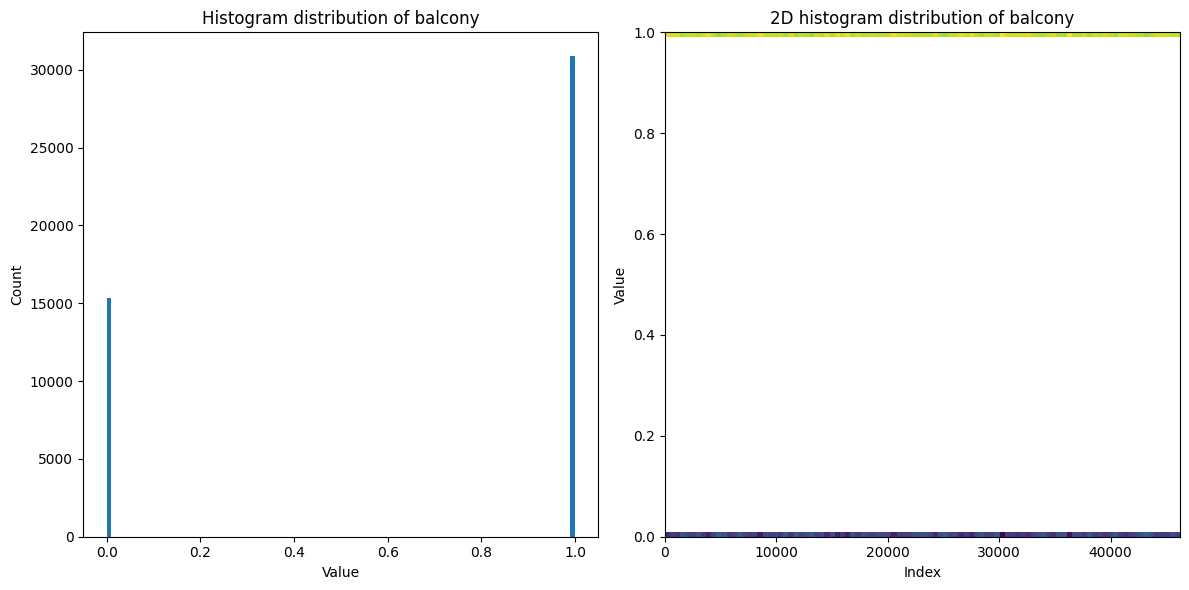

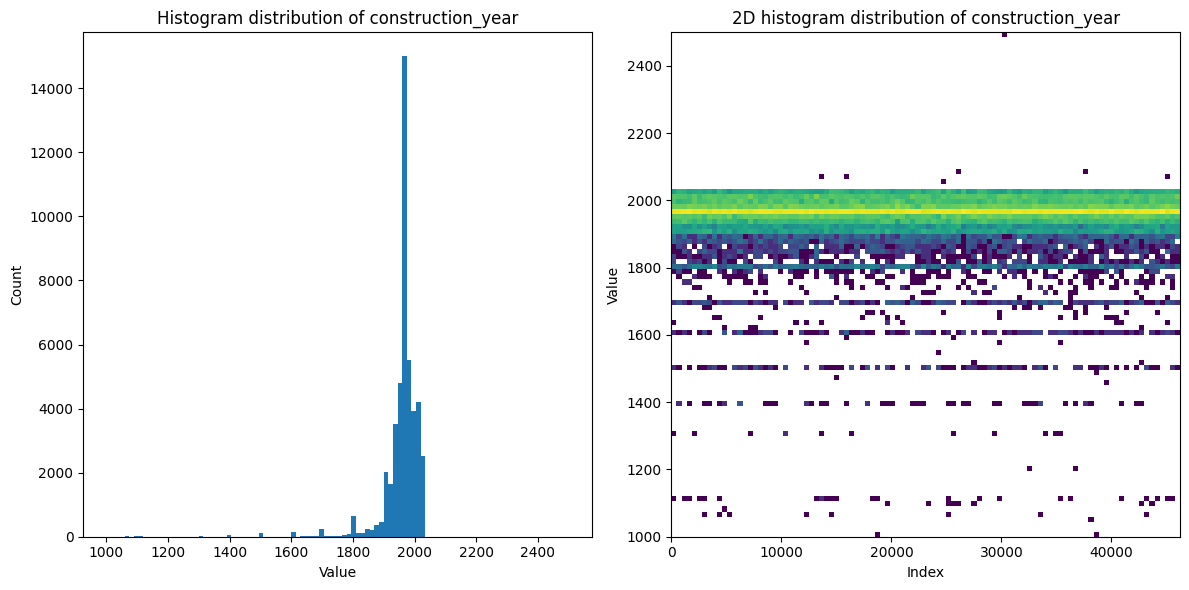

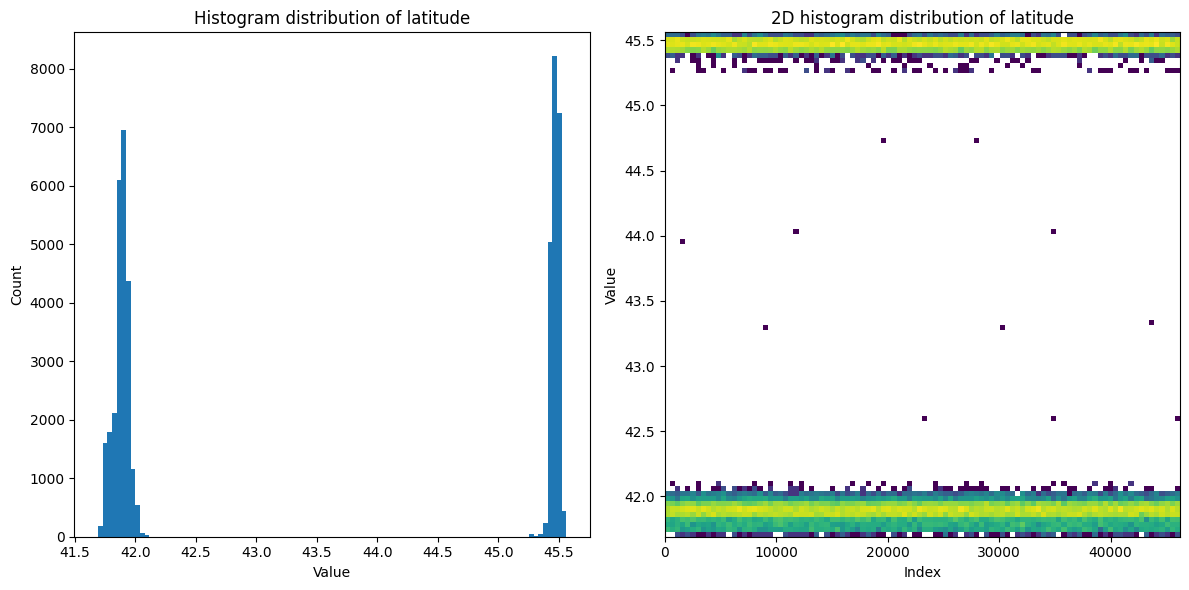

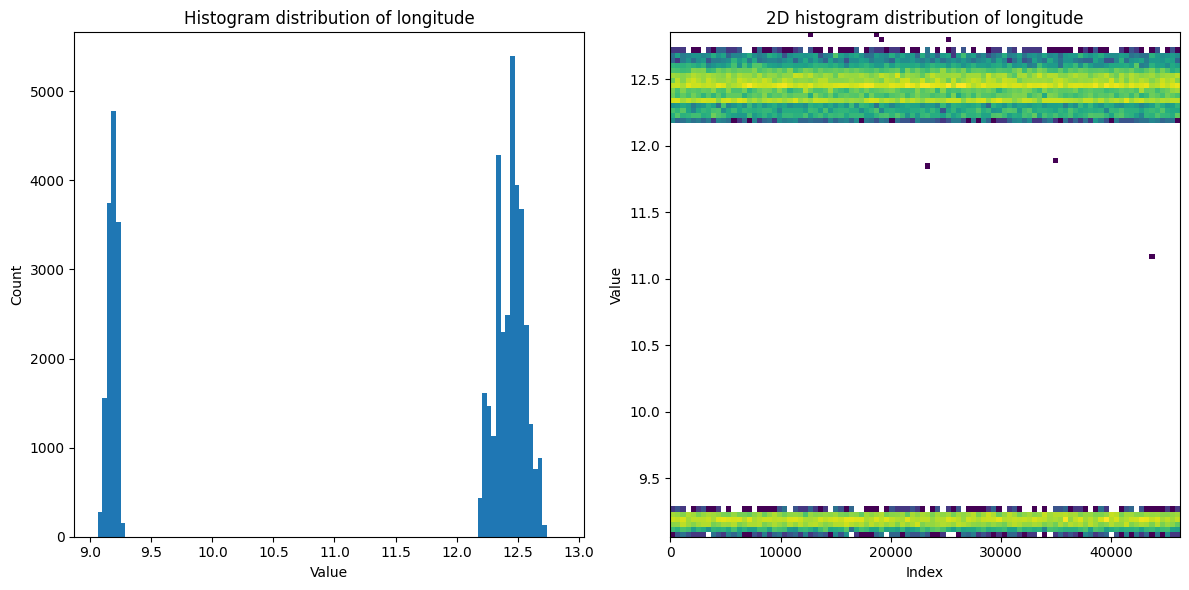

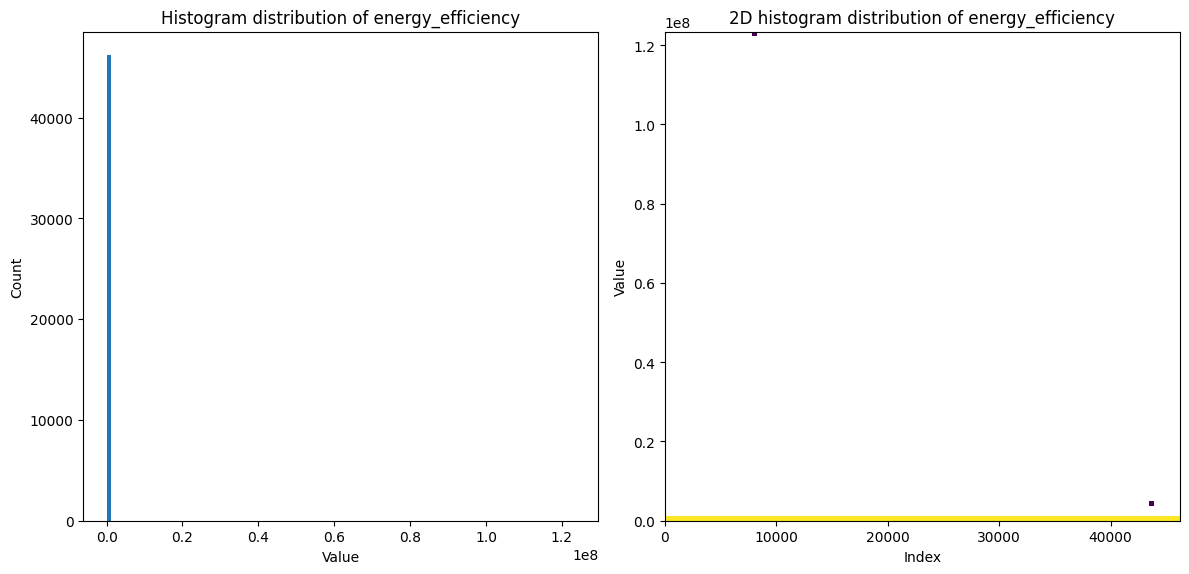

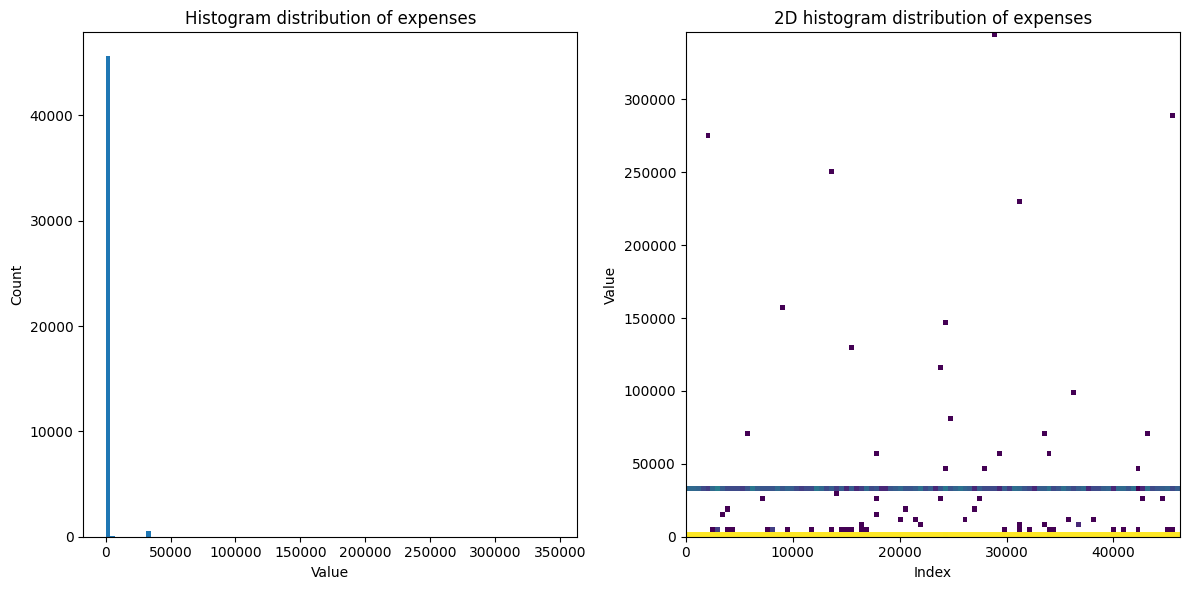

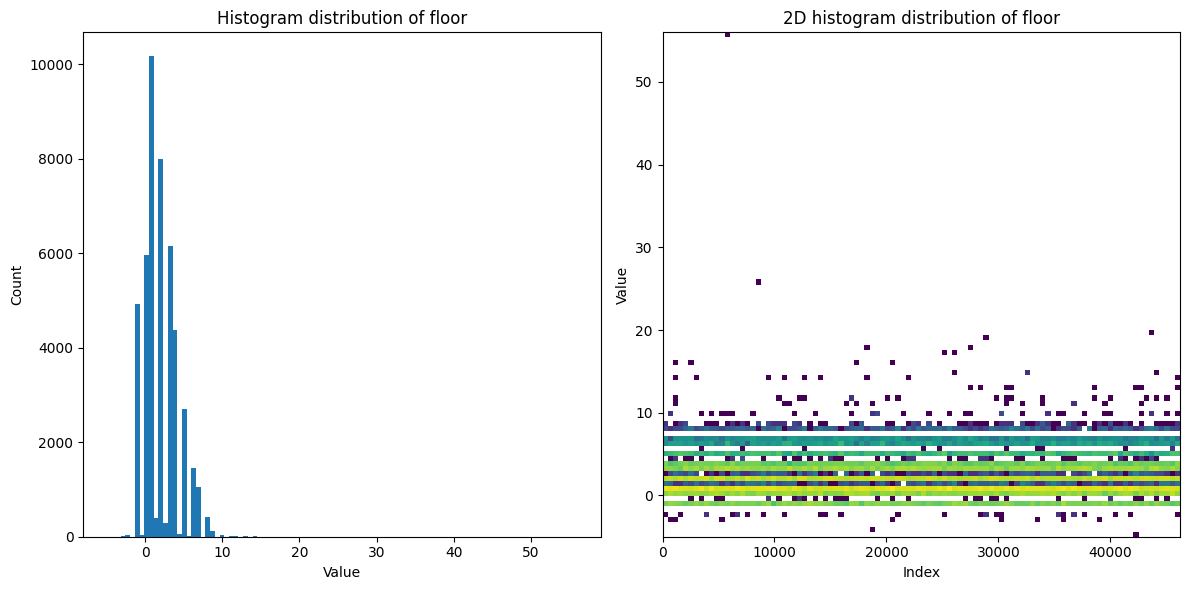

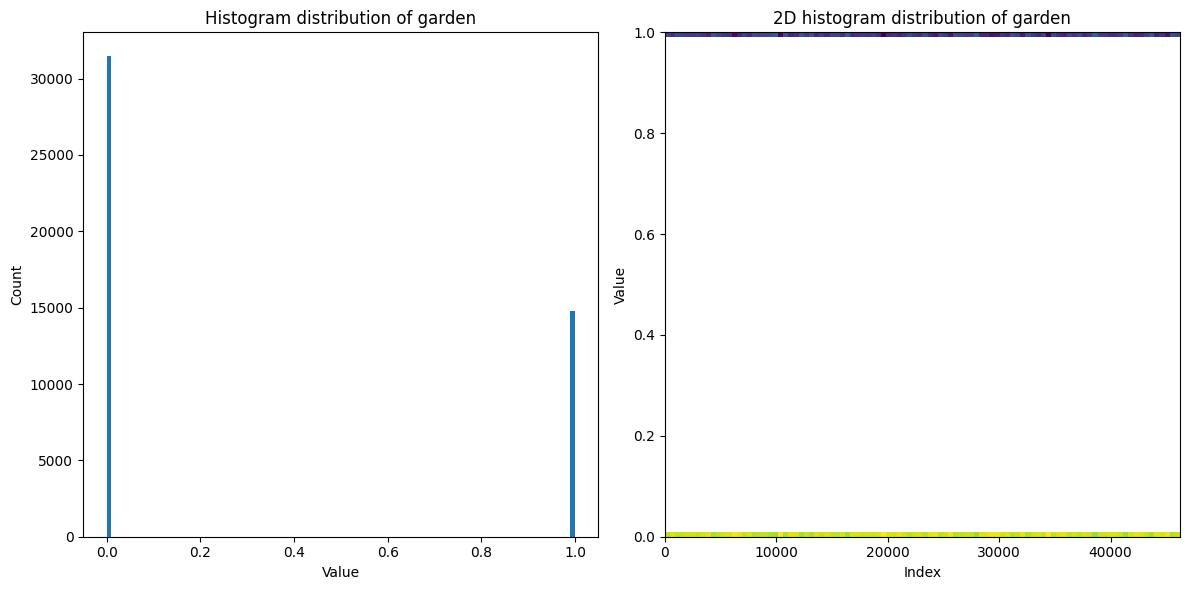

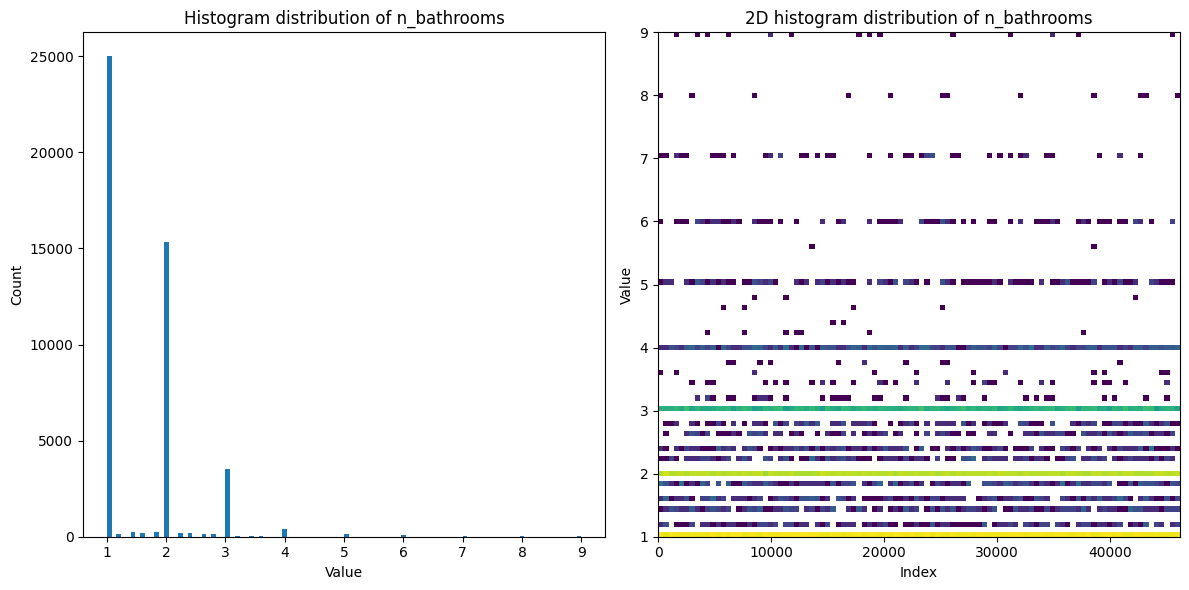

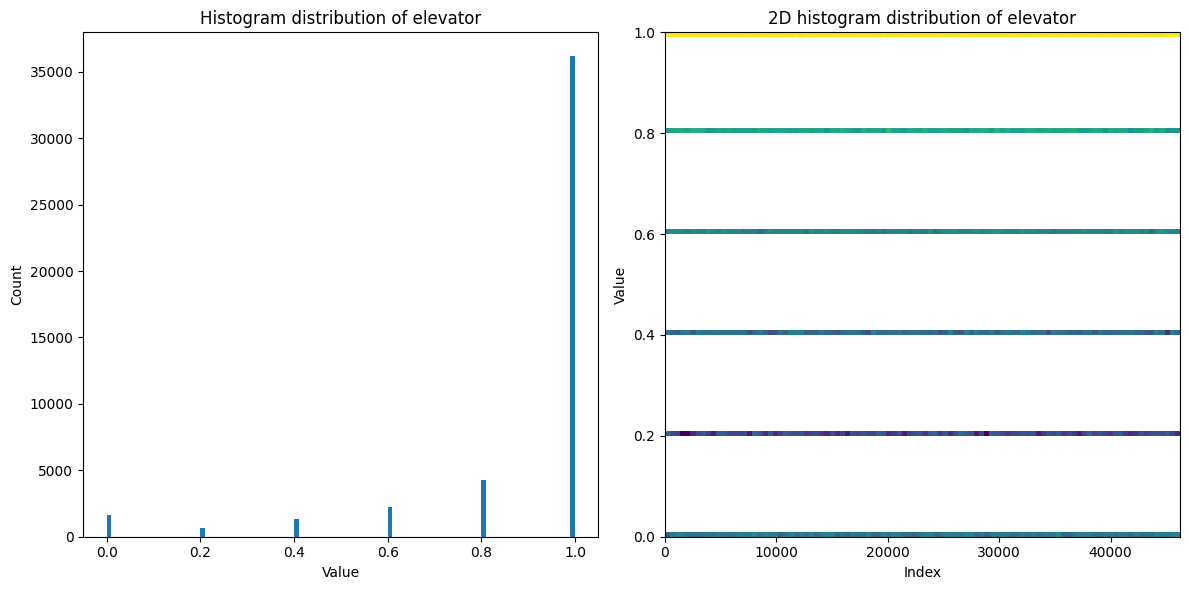

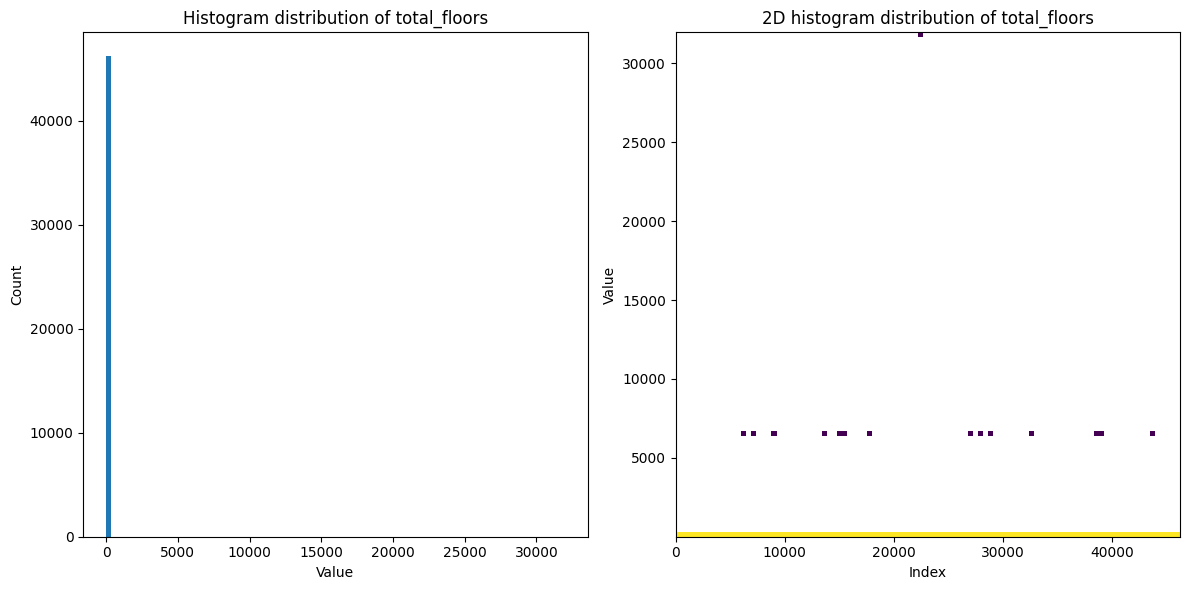

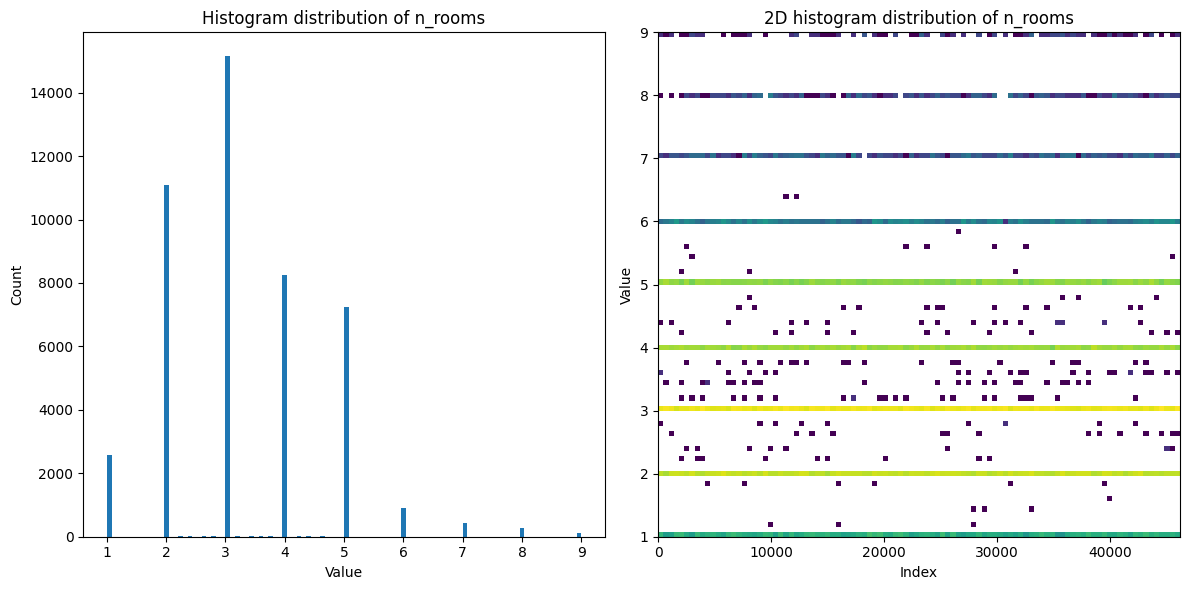

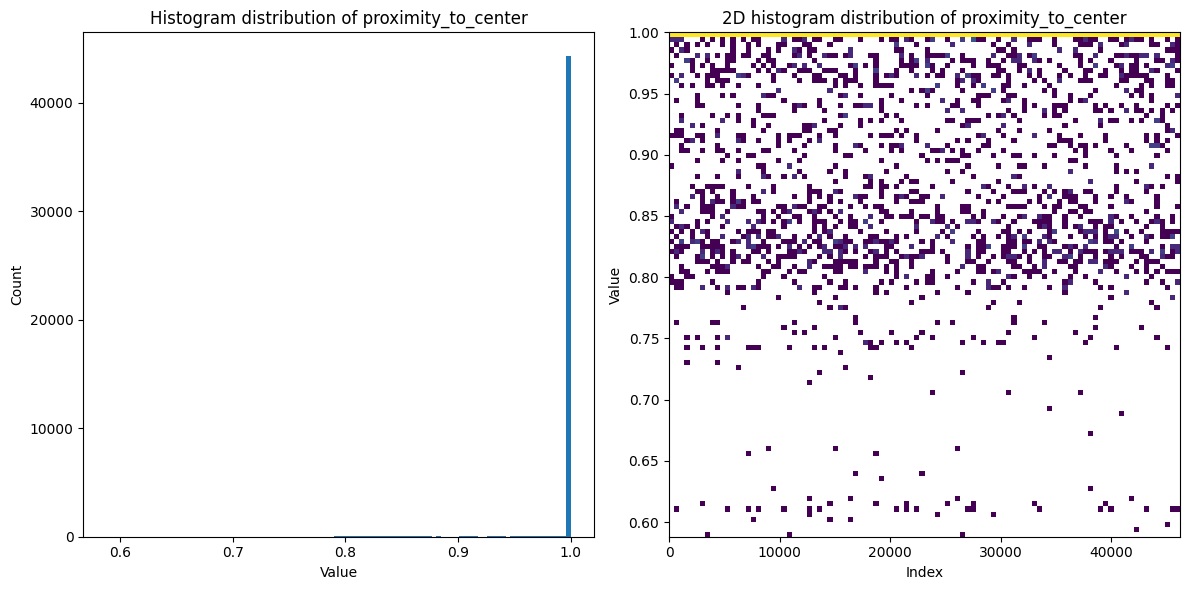

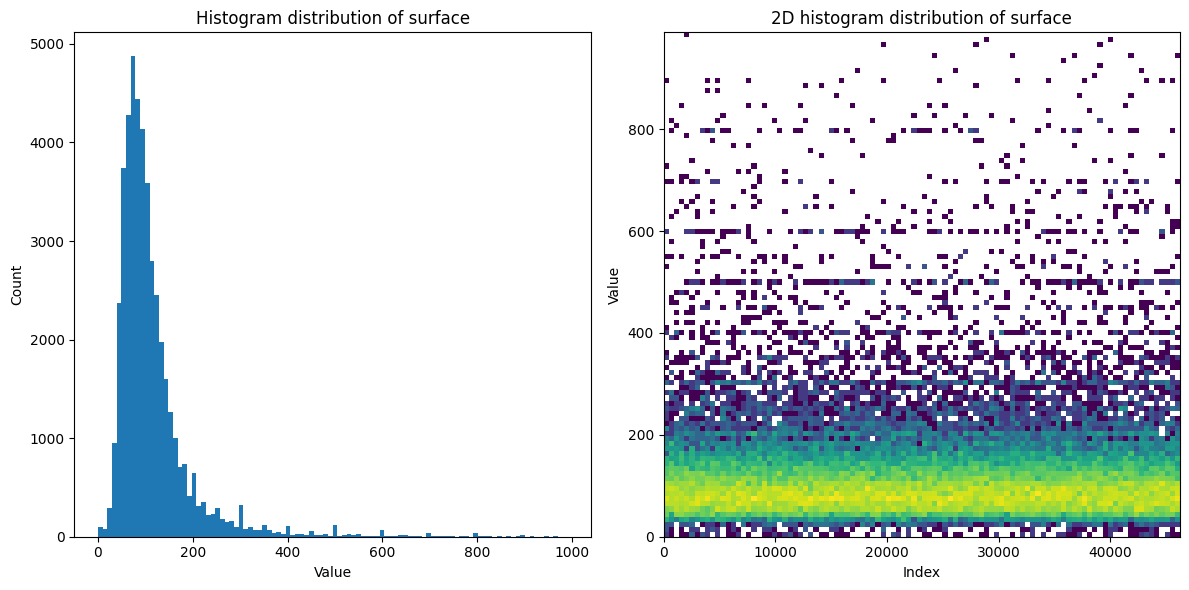

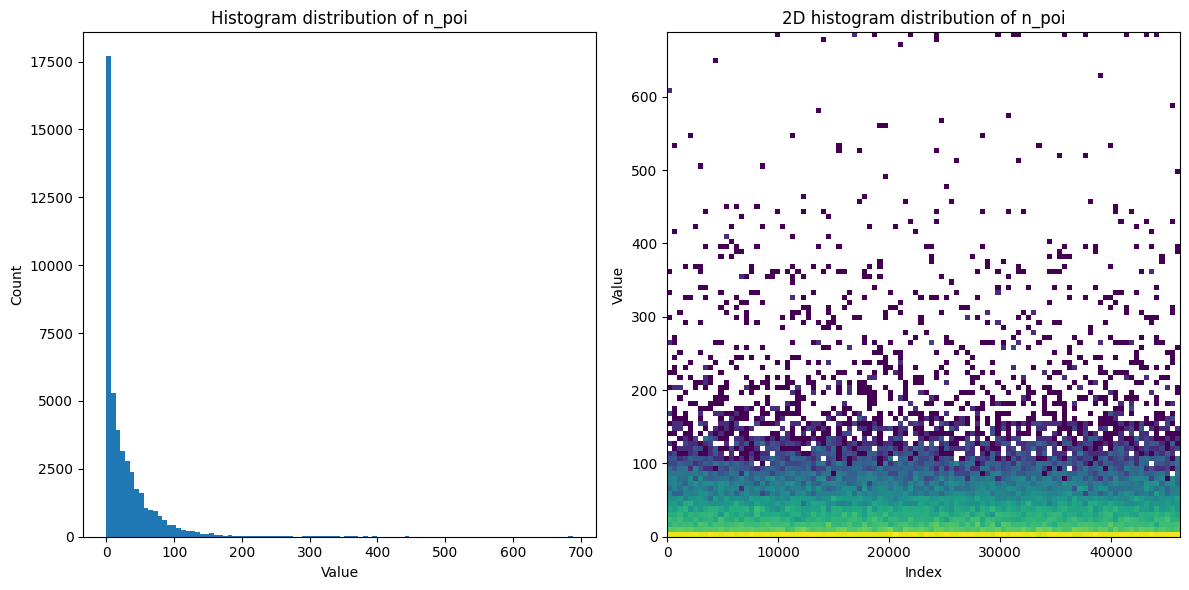

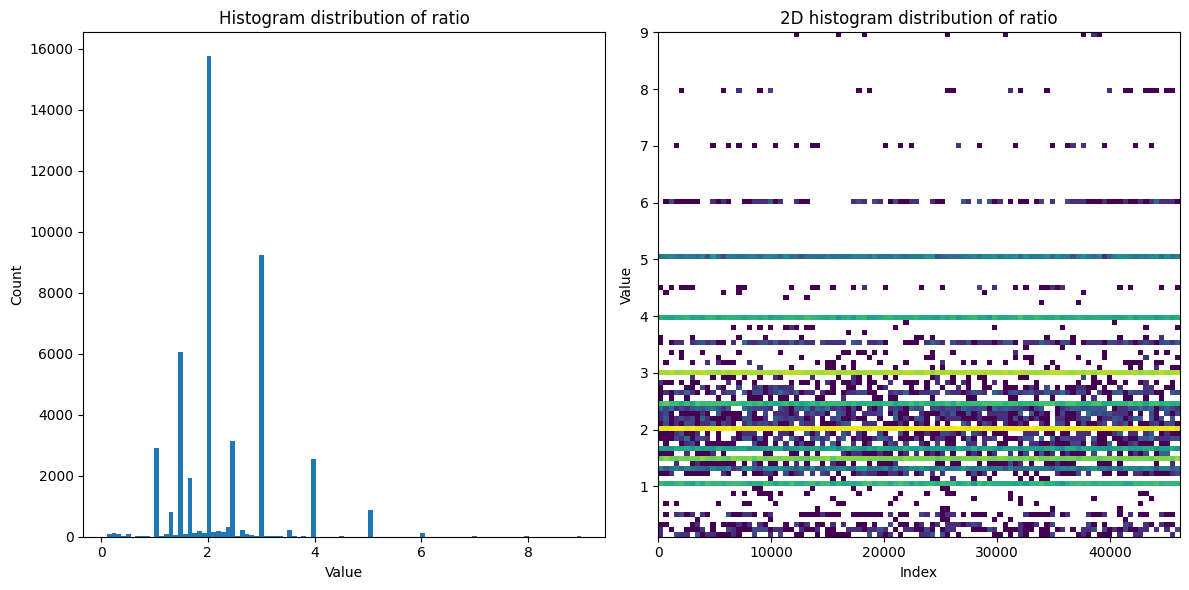

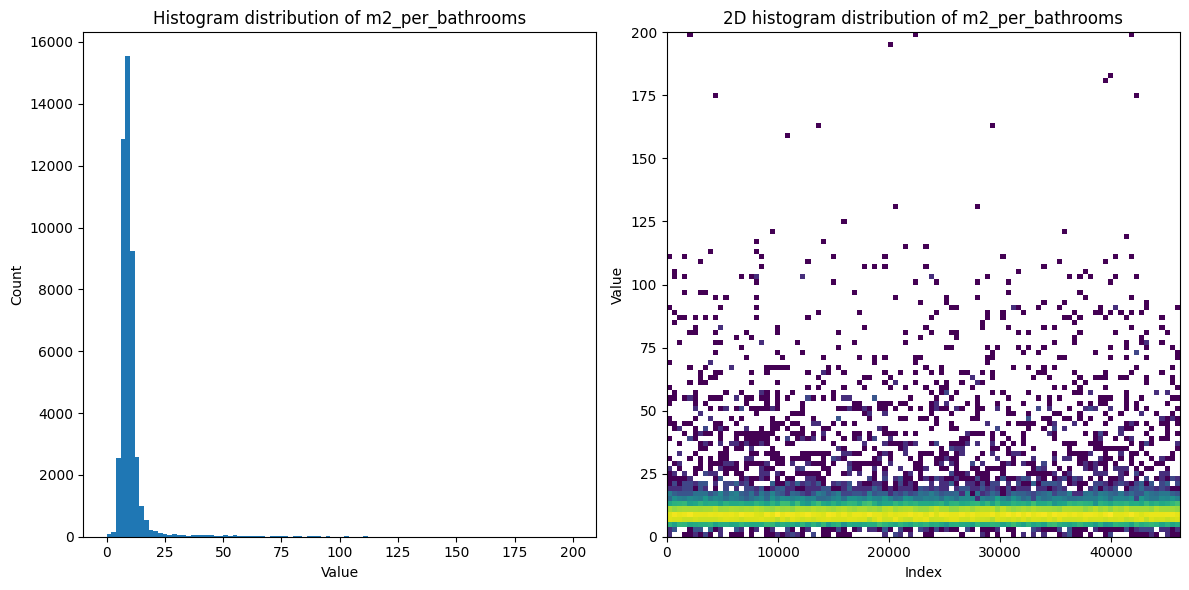

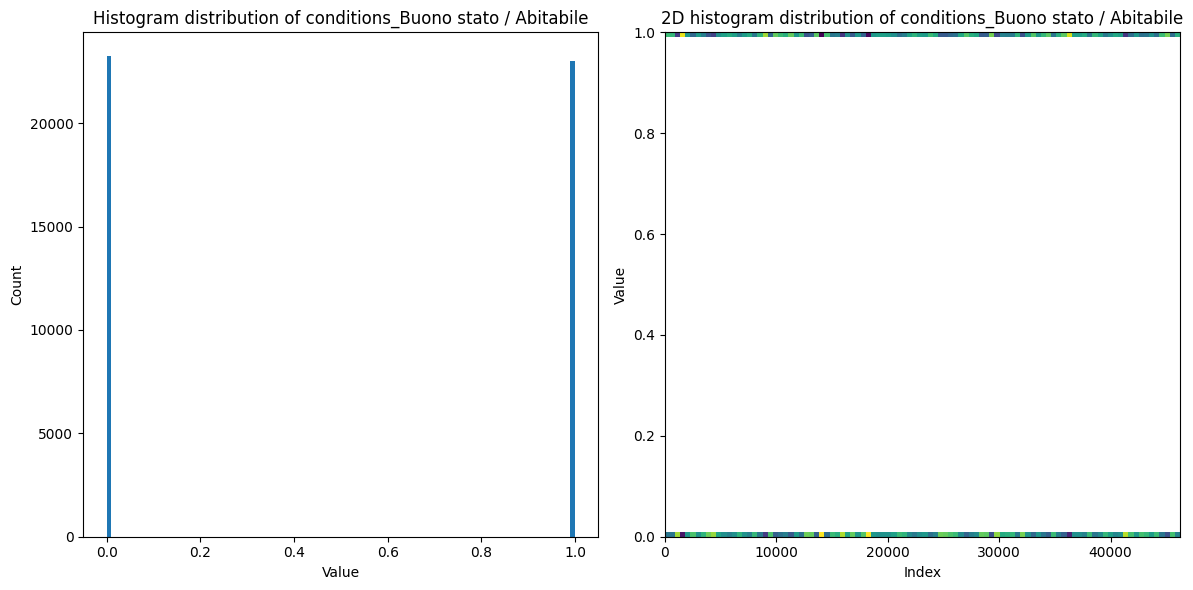

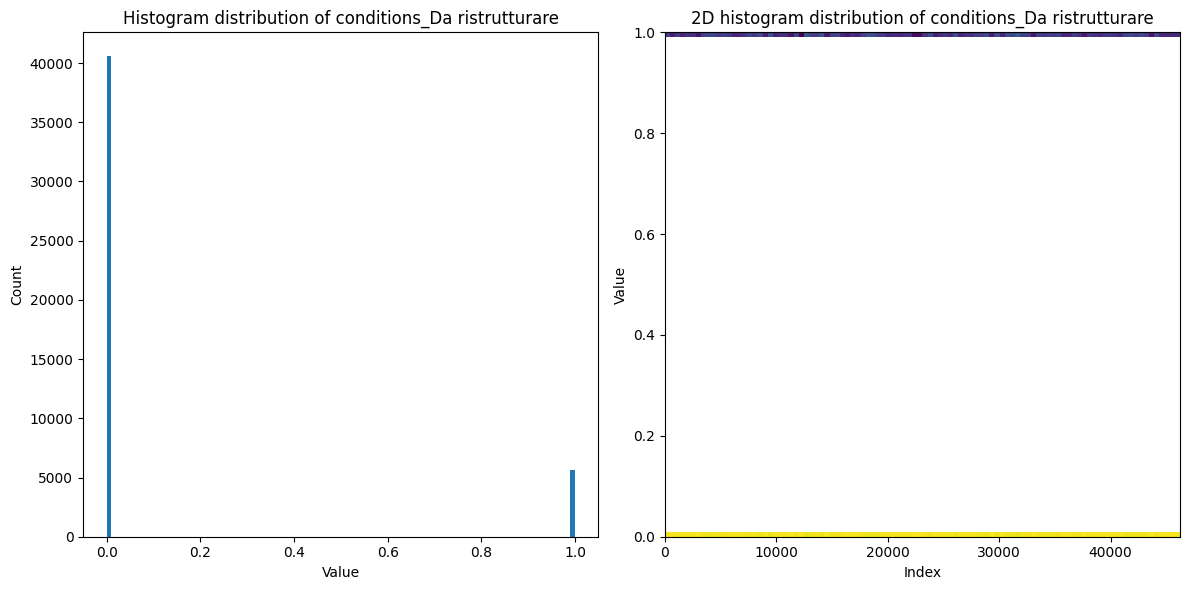

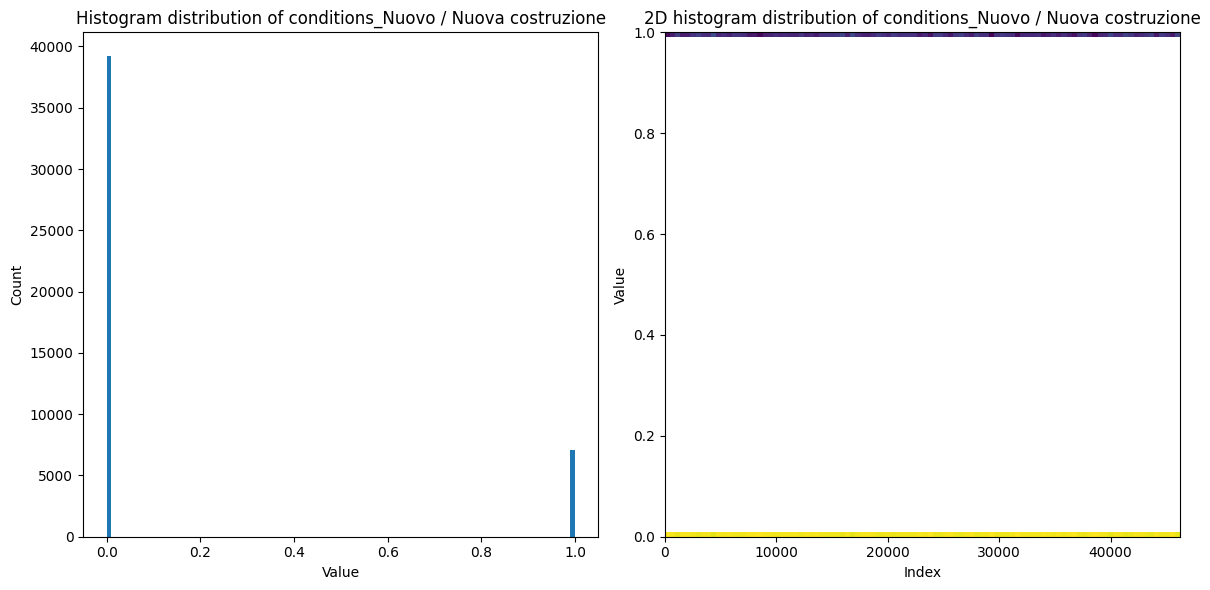

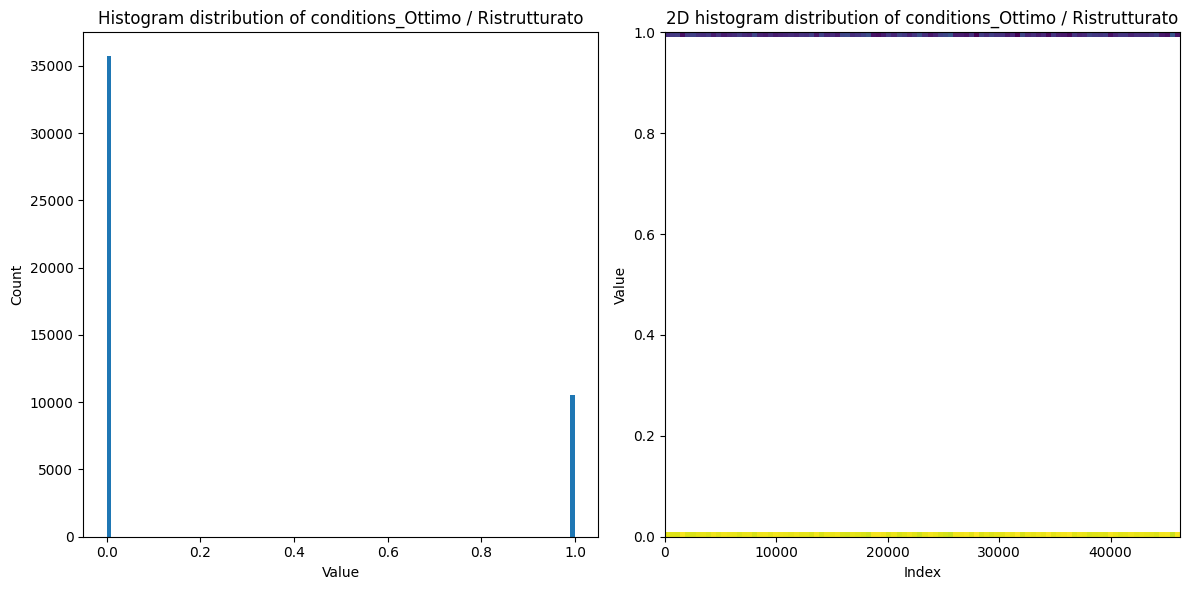

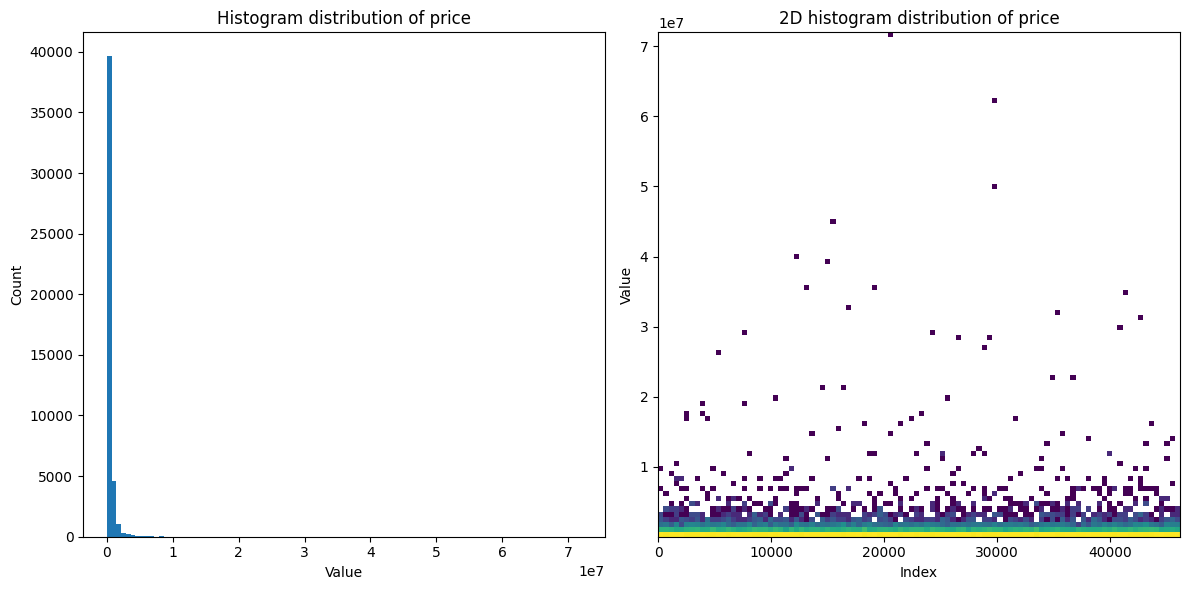

In [42]:
for col in train_df.columns:
    hist_subplot(train_df, col)

We separate the features from the predictions to perform in the best way: StandardScaler

In [43]:
x_train = train_df.drop('price', axis=1)
y_train = train_df['price']

We scale all the features. 

In [44]:
x_scaler = StandardScaler()
x_train = pd.DataFrame(x_scaler.fit_transform(x_train), columns=x_train.columns)
y_scaler = StandardScaler()
y_train = pd.DataFrame(y_scaler.fit_transform(y_train.values.reshape(-1, 1)), columns=['price']) #reshaping is necessary because StandardScaler() expects a 2D array as inpu

In [45]:
train_df = pd.concat([x_train, y_train], axis=1)

We then plot again the histograms for all the columns of train_df to see how both how all the features have almost the same scale and are in the range (-1, 1). 

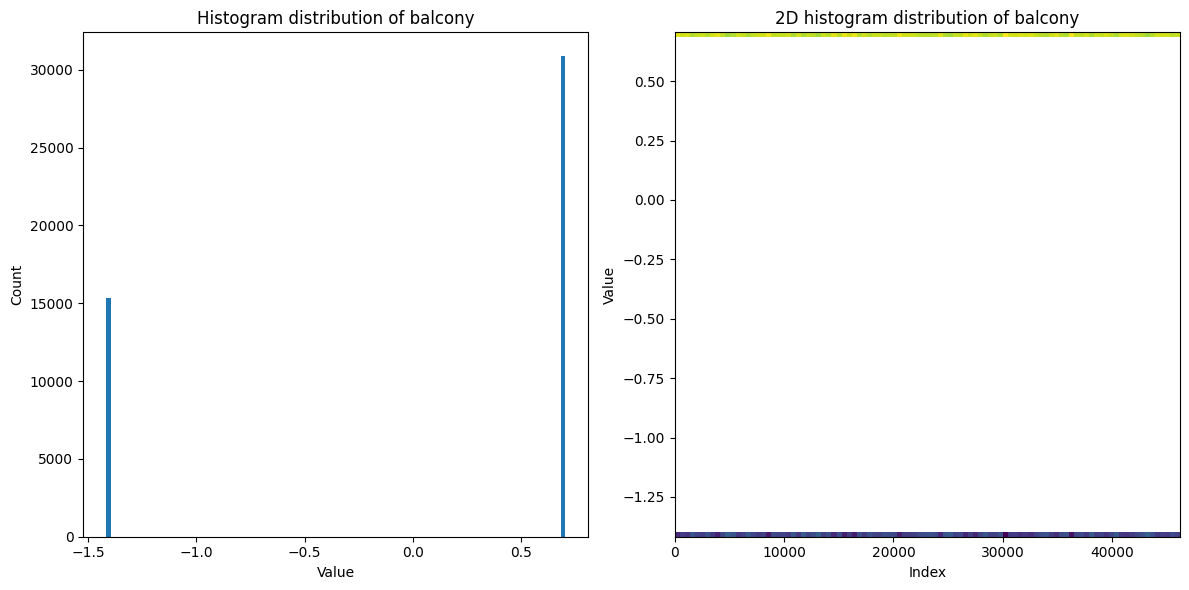

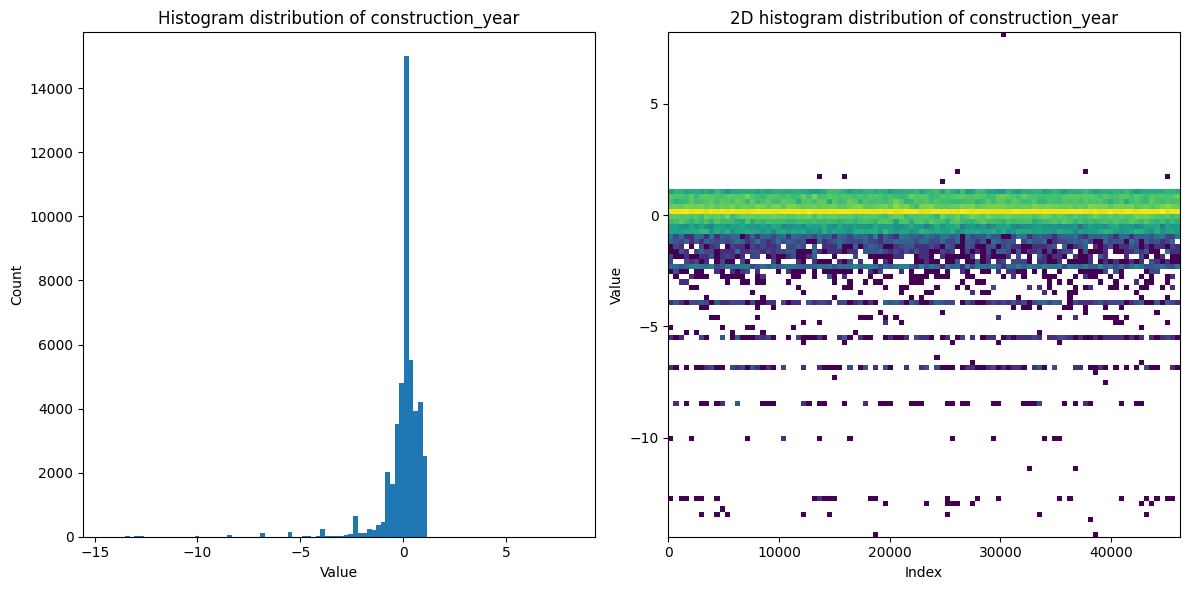

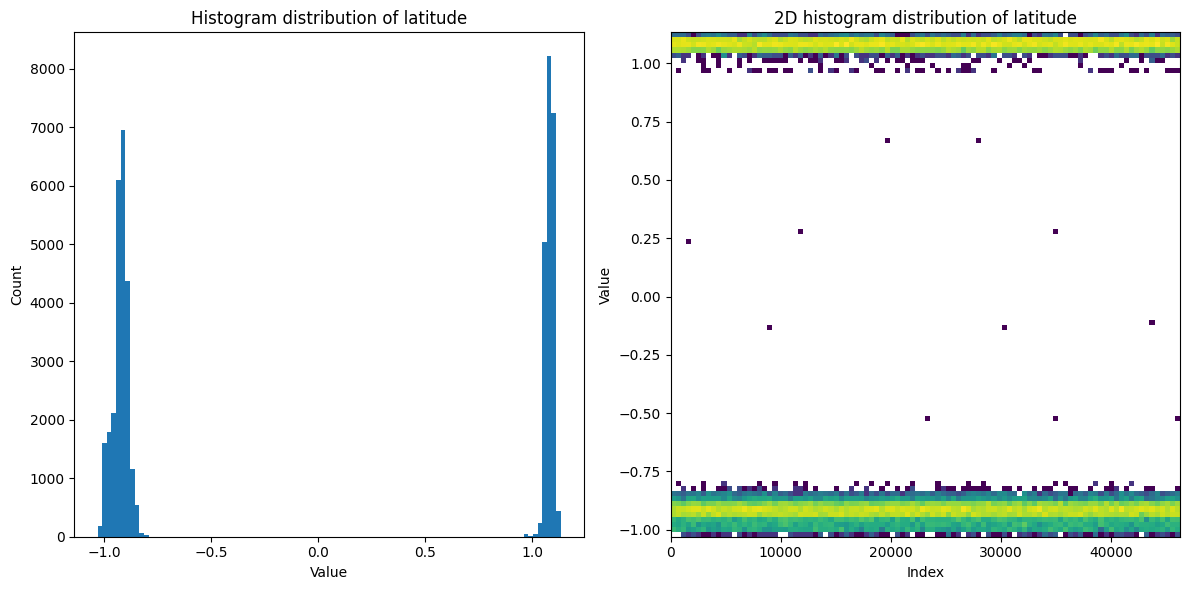

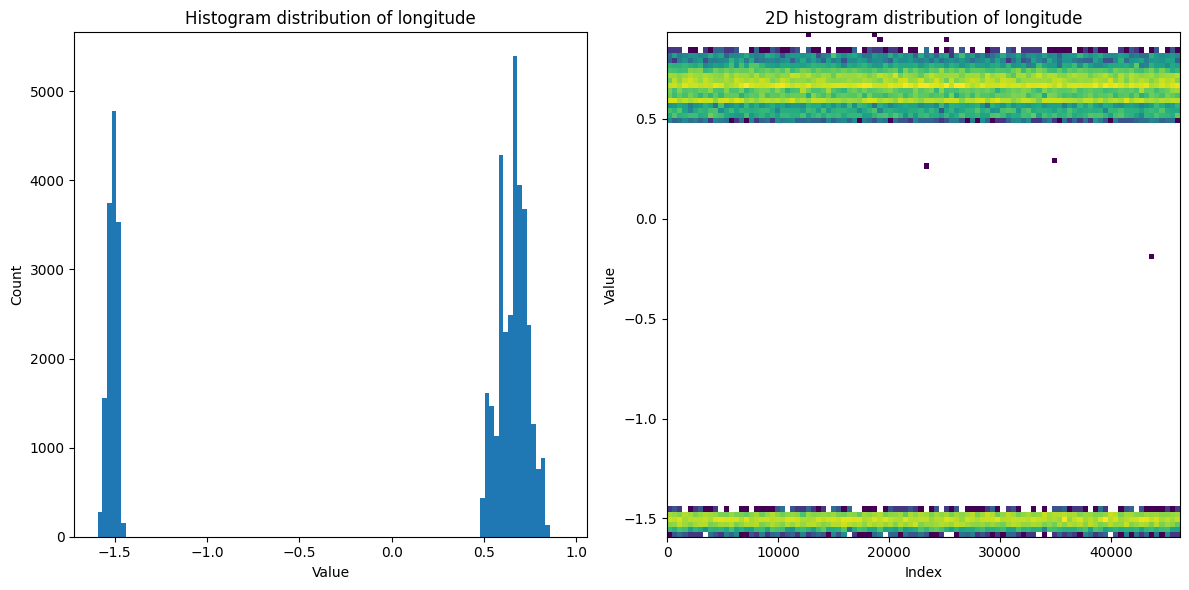

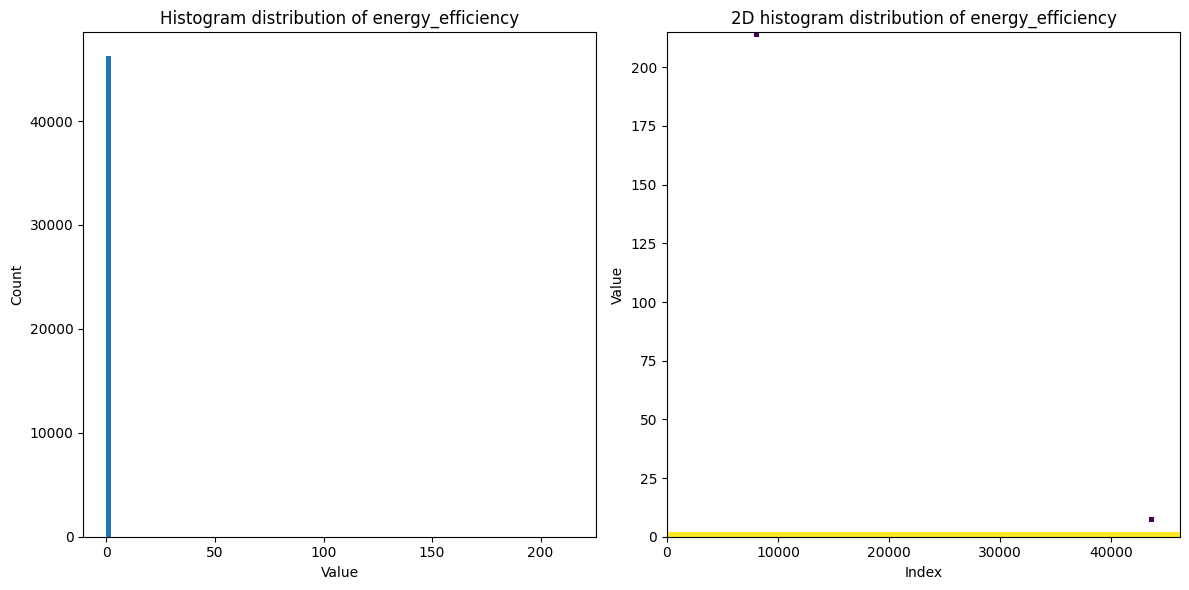

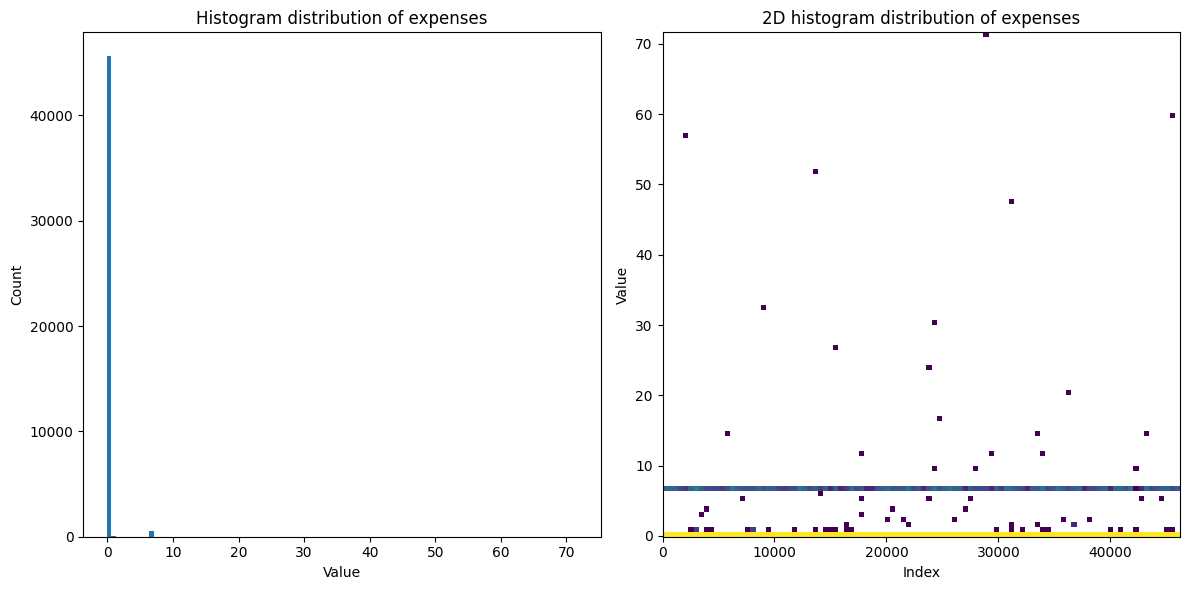

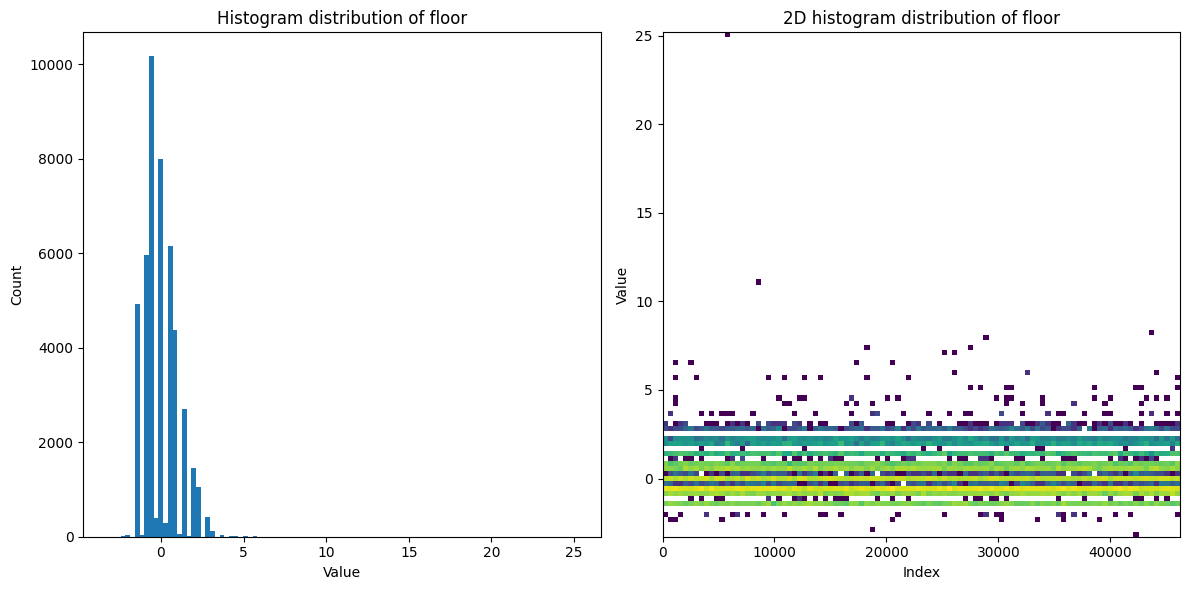

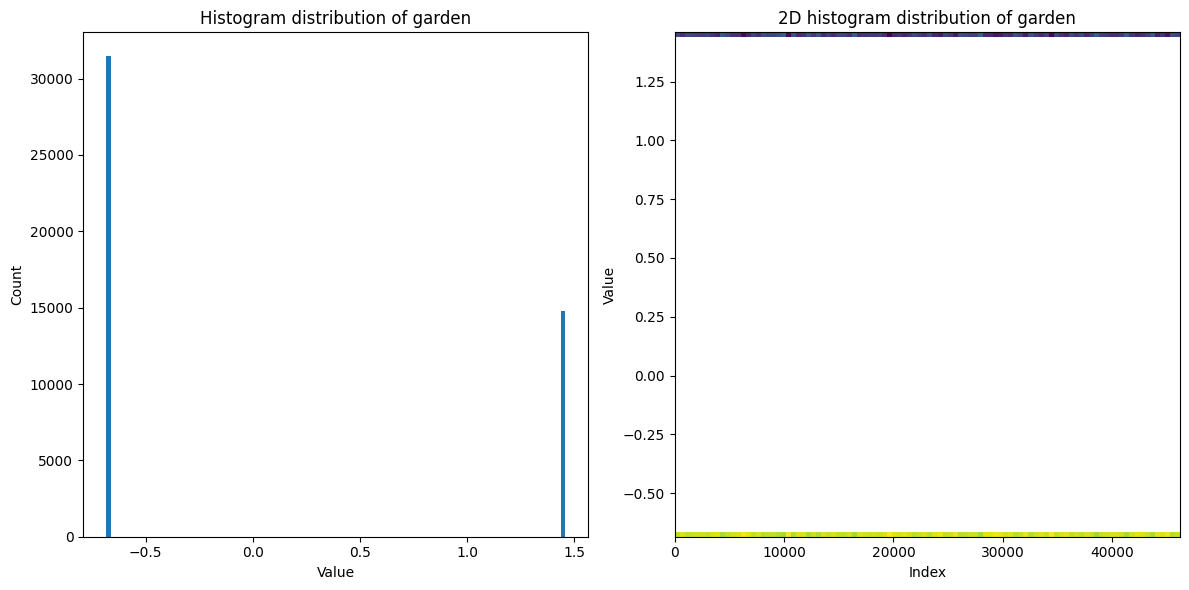

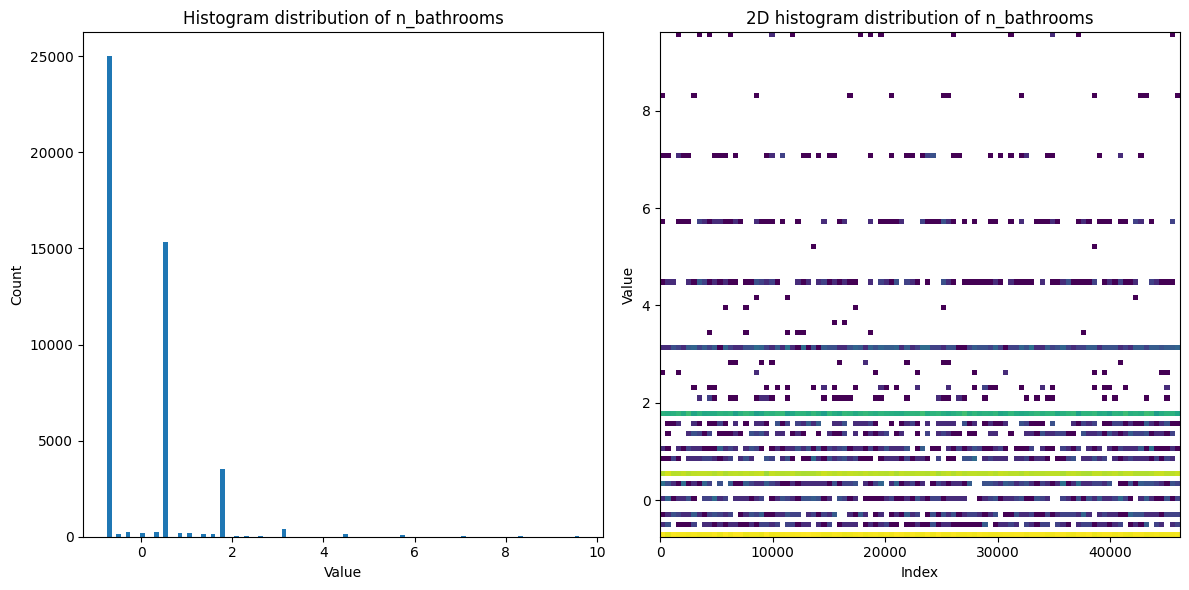

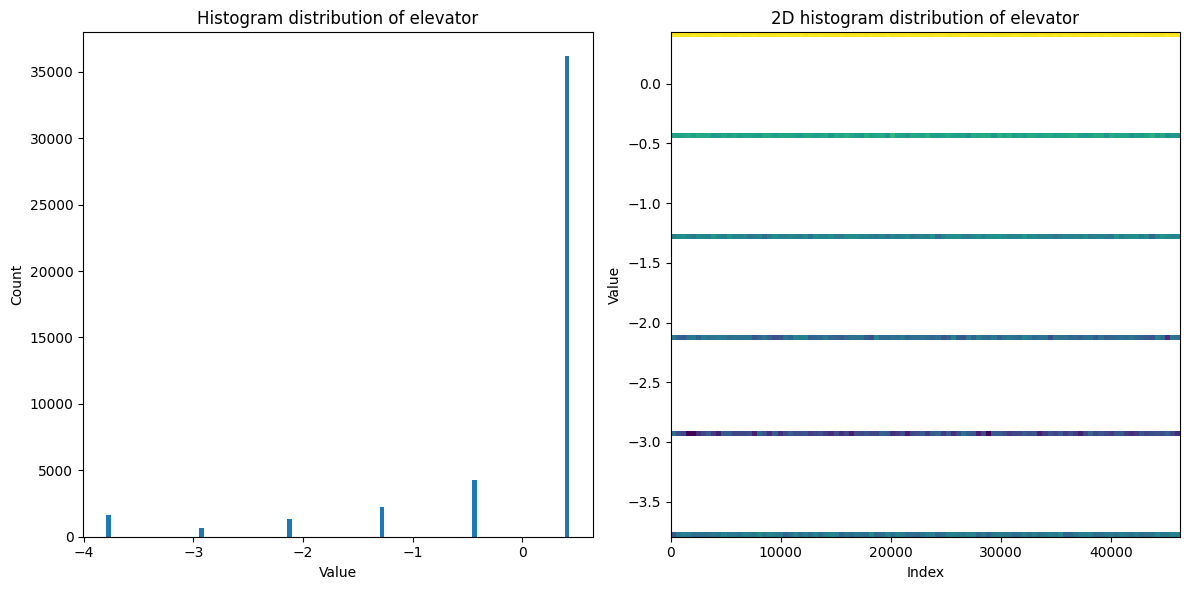

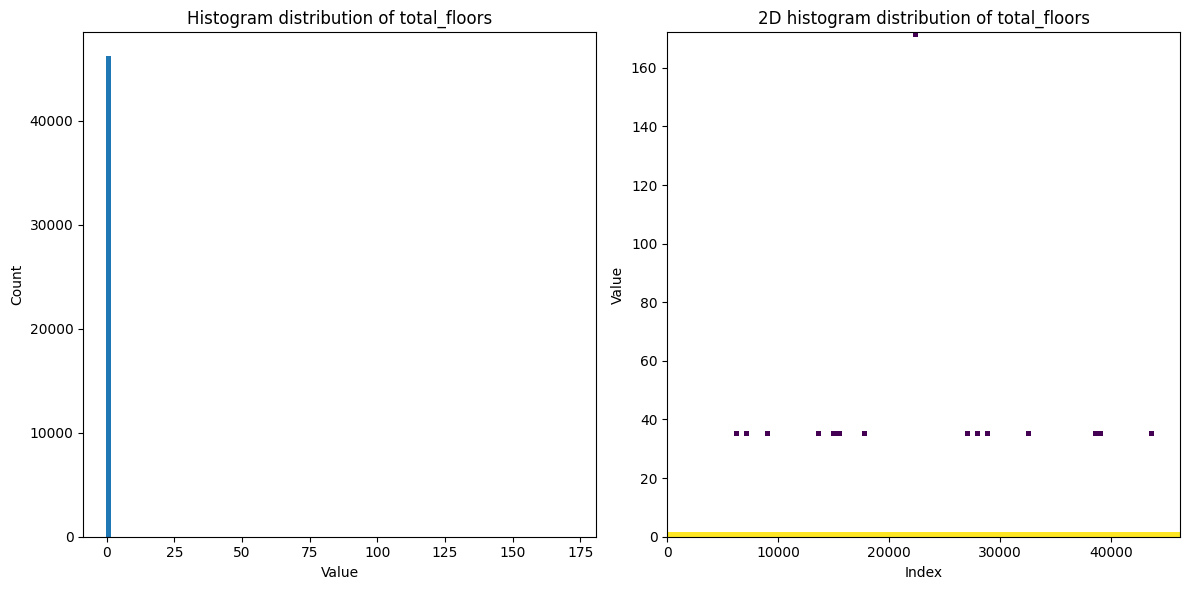

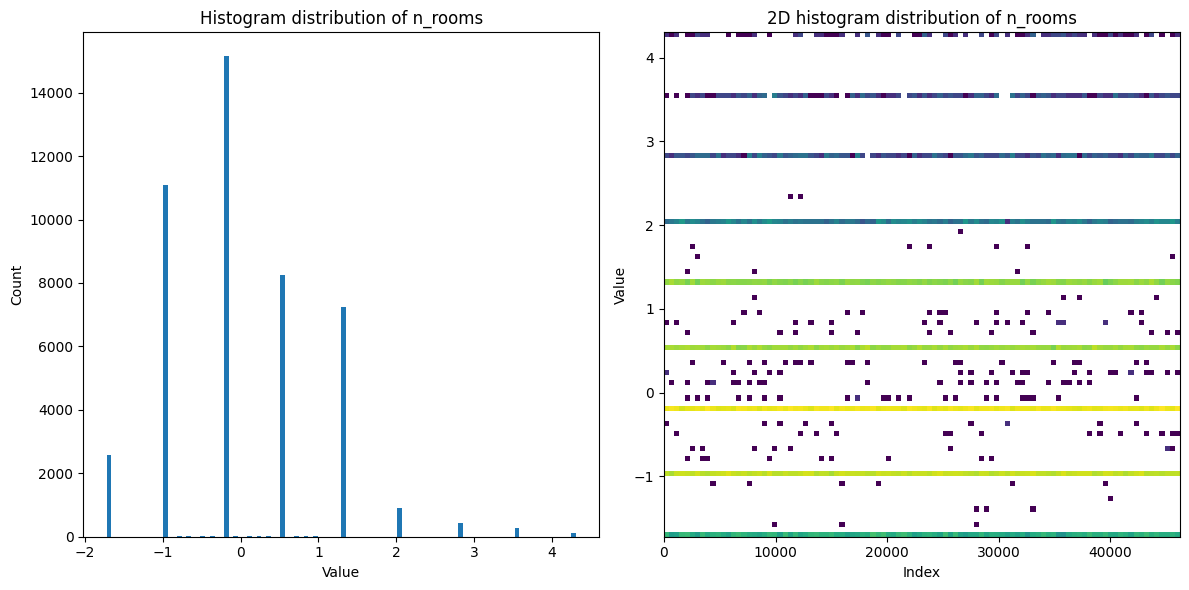

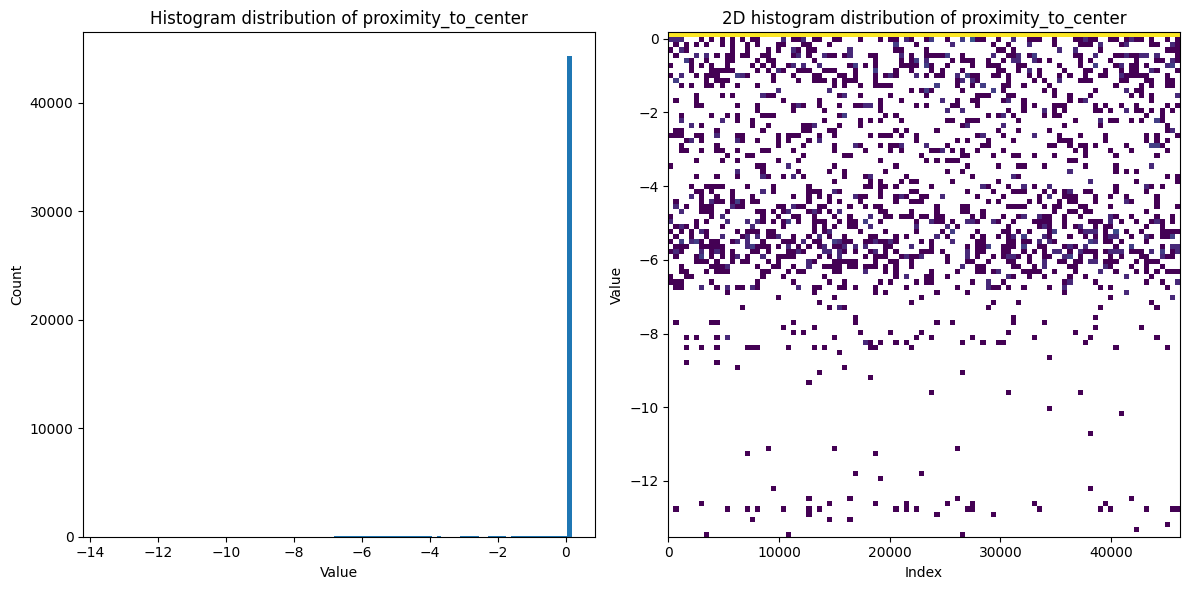

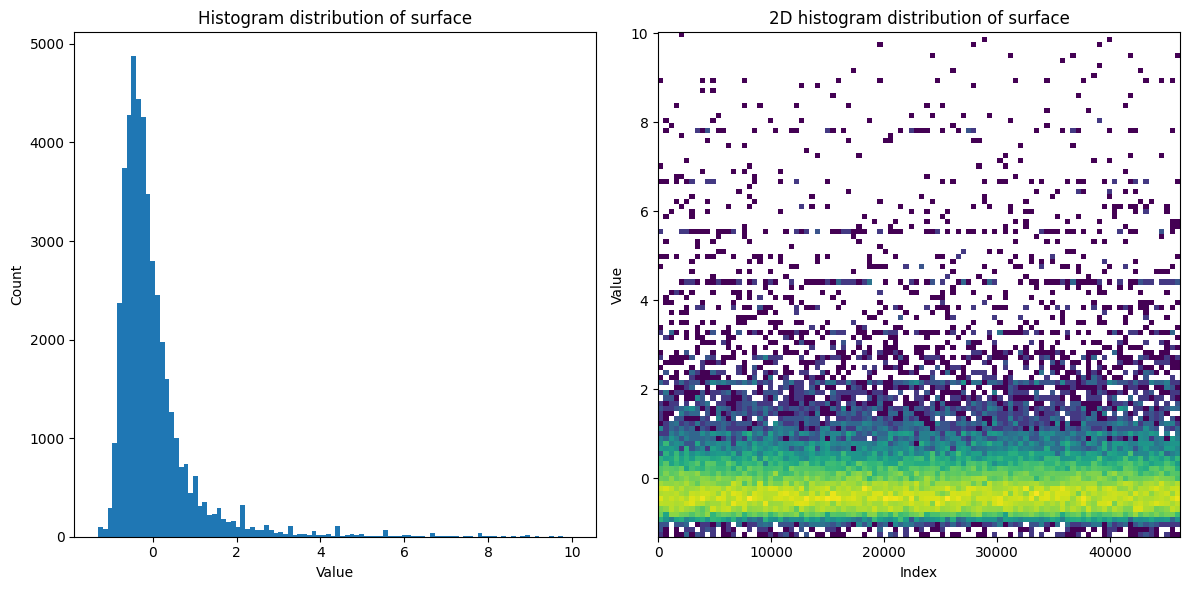

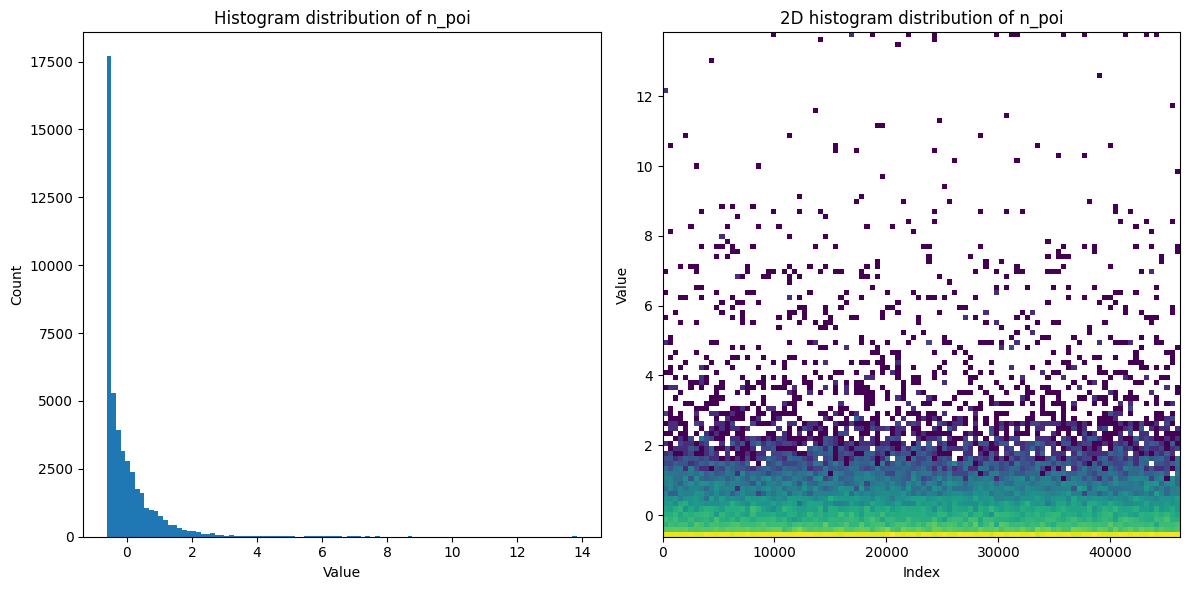

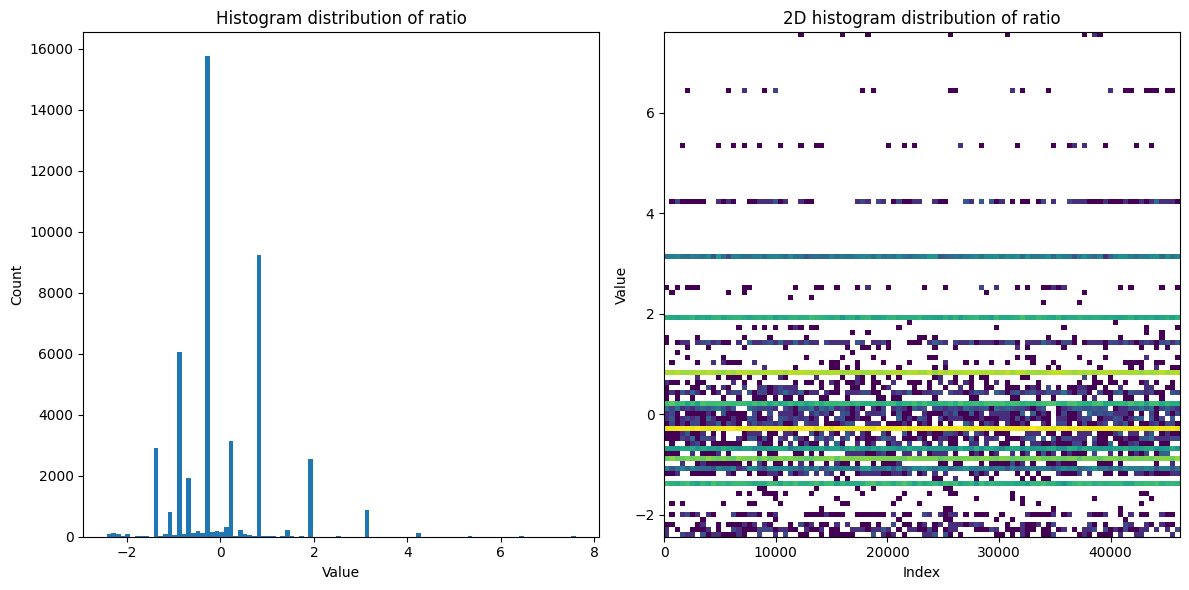

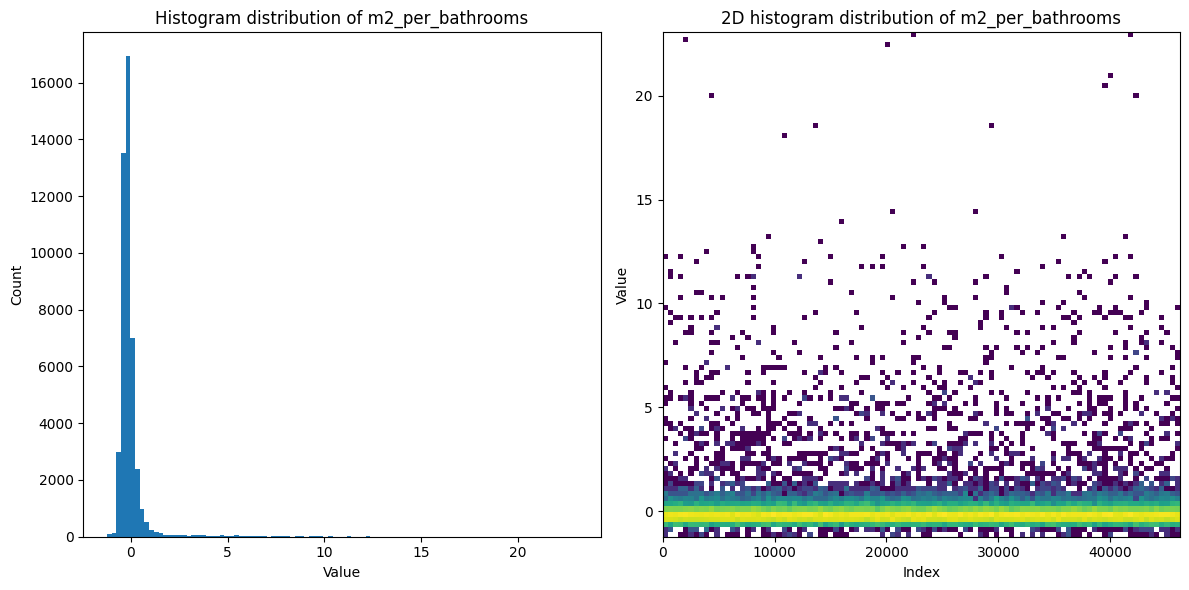

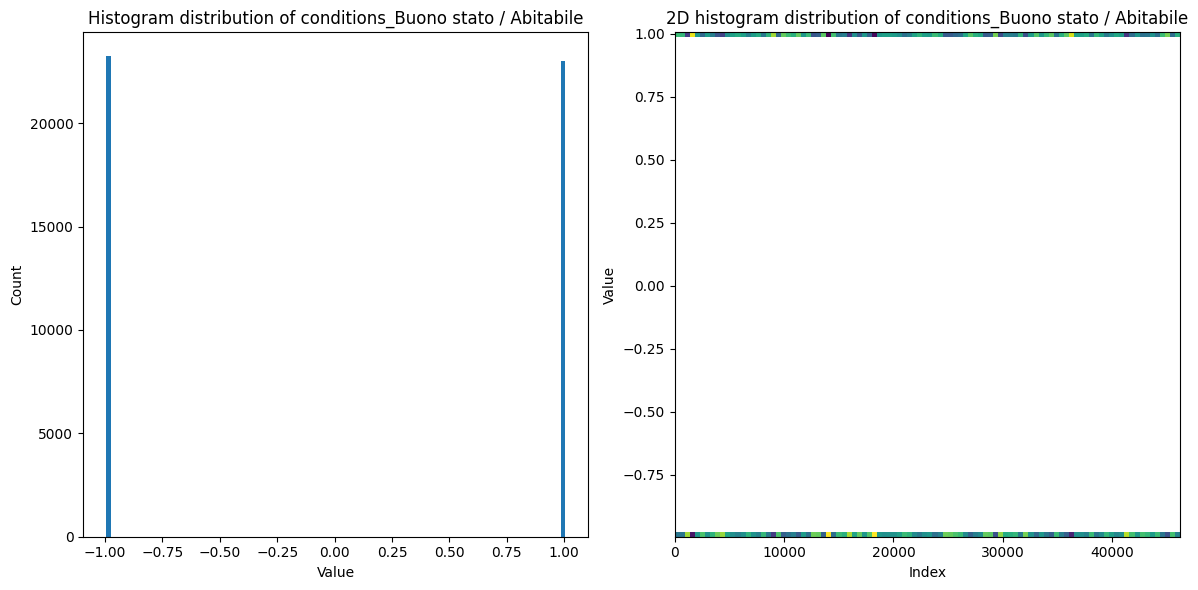

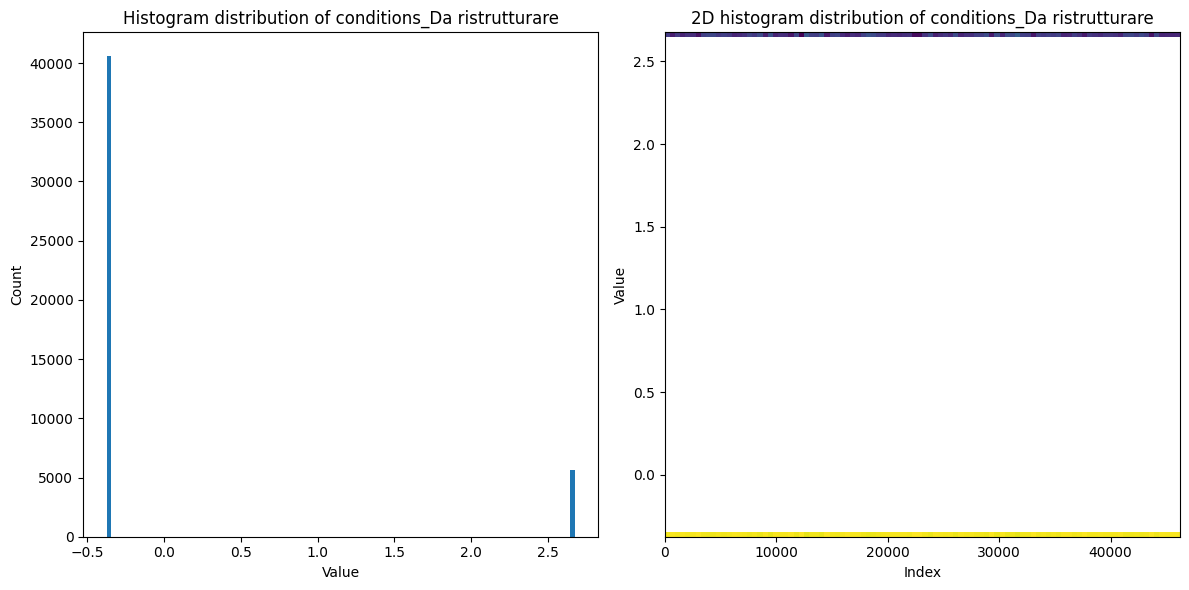

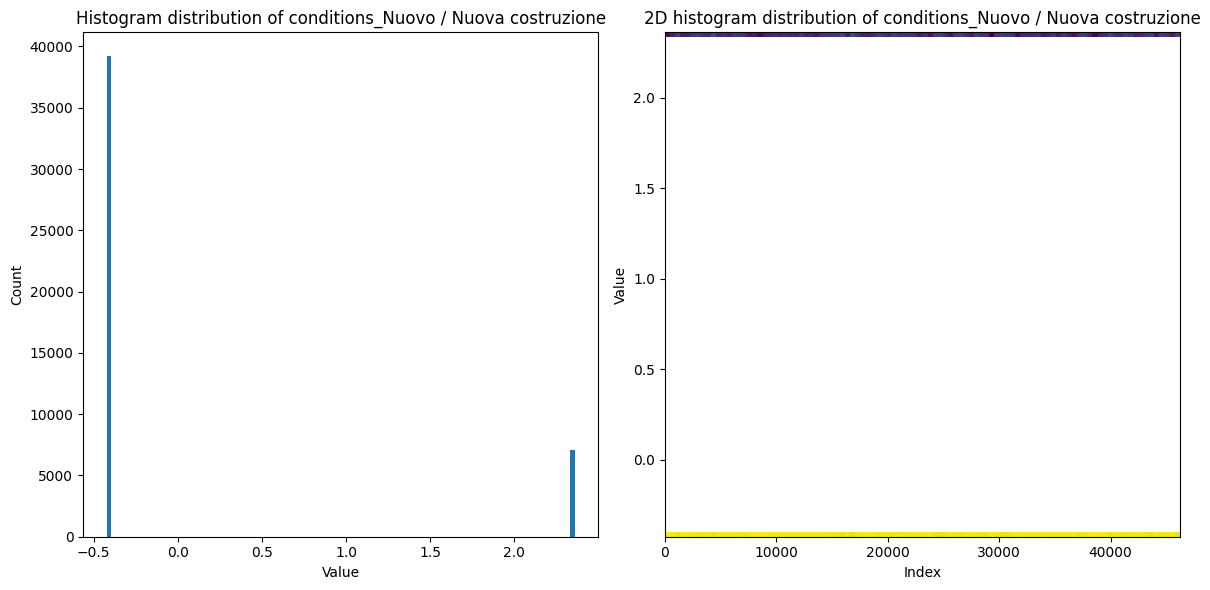

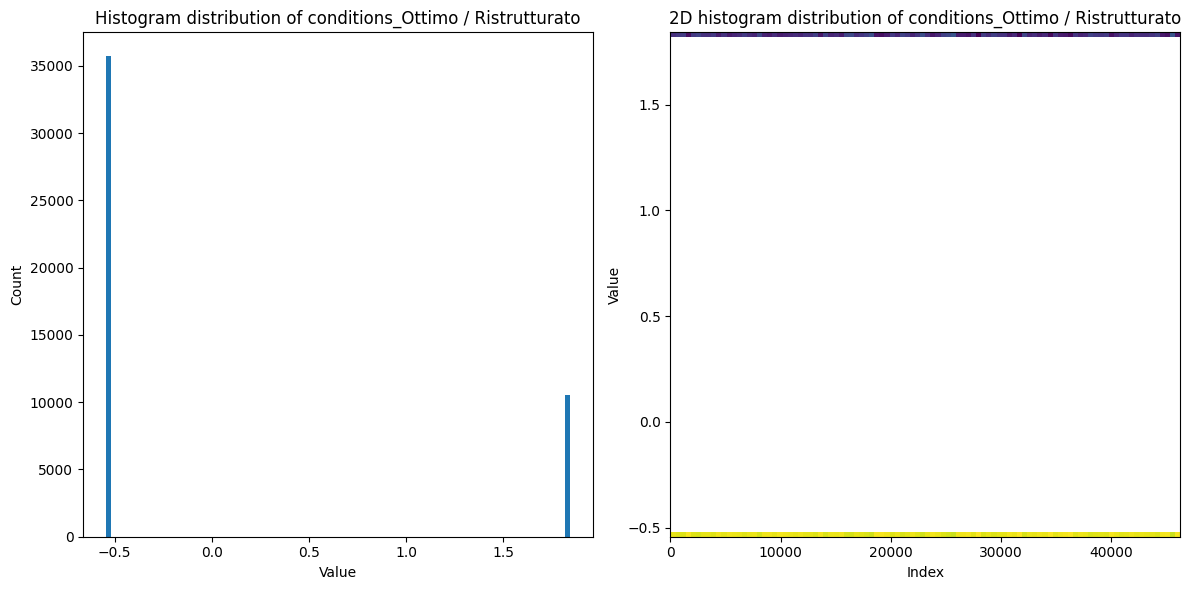

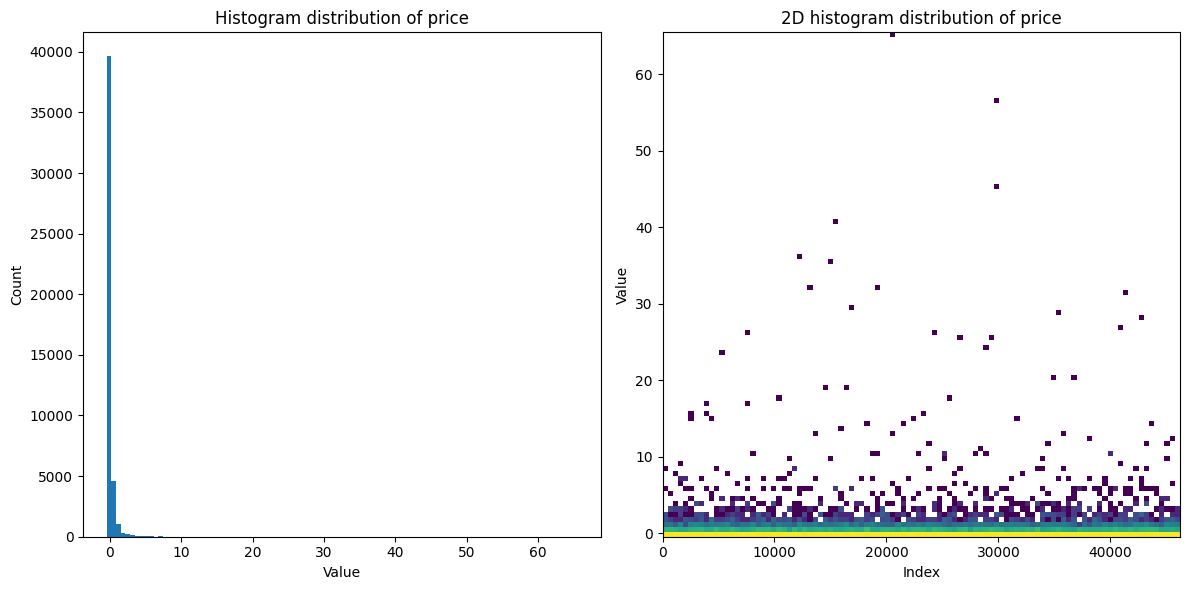

In [46]:
for col in train_df.columns:
    hist_subplot(train_df, col)

# 2.2. Drop Outliers

We now drop the outliers of all the columns in our train_df using the z_score. In particularly we decide to keep all the values in each feature that are within 5 standard deviations from the mean. 

In [47]:
original_shape = train_df.shape[0]
z_scores = zscore(train_df) #compute the zscore for all the features in train_df
abs_z_scores = np.abs(z_scores) #calculate the absolute z-scores for each feature
filtered_entries = (abs_z_scores < 5).all(axis=1) # create a boolean mask that is True for all rows where the absolute z-score for all features is less than 5

In [48]:
train_df = train_df[filtered_entries].reset_index(drop=True) #filter train_df using the before defined boolean mask
shape_t2 = train_df.shape[0] #number of rows after z-score filtering

In [49]:
print('shape before removing features with many NaNs: {}'.format(shape_t0))
print('shape after removing features with many NaNs: {}'.format(shape_t1))
print('shape difference: {}'.format(shape_t0-shape_t1))
print('percentage of removed rows: {}%'.format(round((shape_t0-shape_t1)*100/shape_t0, 2)))
print()
print('shape before removing outliers: {}'.format(shape_t1))
print('shape after removing outliers: {}'.format(shape_t2))
print('shape difference: {}'.format(shape_t1-shape_t2))
print('percentage of removed rows: {}%'.format(round((shape_t1-shape_t2)*100/shape_t1, 2)))
print()
print('shape beafore removing outliers and NaNs: {}'.format(shape_t0))
print('shape after removing outliers and NaNs: {}'.format(shape_t2))
print('shape difference: {}'.format(shape_t0-shape_t2))
print('percentage of removed rows: {}%'.format(round((shape_t0-shape_t2)*100/shape_t0, 2)))

shape before removing features with many NaNs: 46312
shape after removing features with many NaNs: 46229
shape difference: 83
percentage of removed rows: 0.18%

shape before removing outliers: 46229
shape after removing outliers: 43478
shape difference: 2751
percentage of removed rows: 5.95%

shape beafore removing outliers and NaNs: 46312
shape after removing outliers and NaNs: 43478
shape difference: 2834
percentage of removed rows: 6.12%


At the end of the trasformations and the removal of the outliers we plot histograms for all train_df columns and we can see that we have better and cleaner distribution with respect to the begging. 

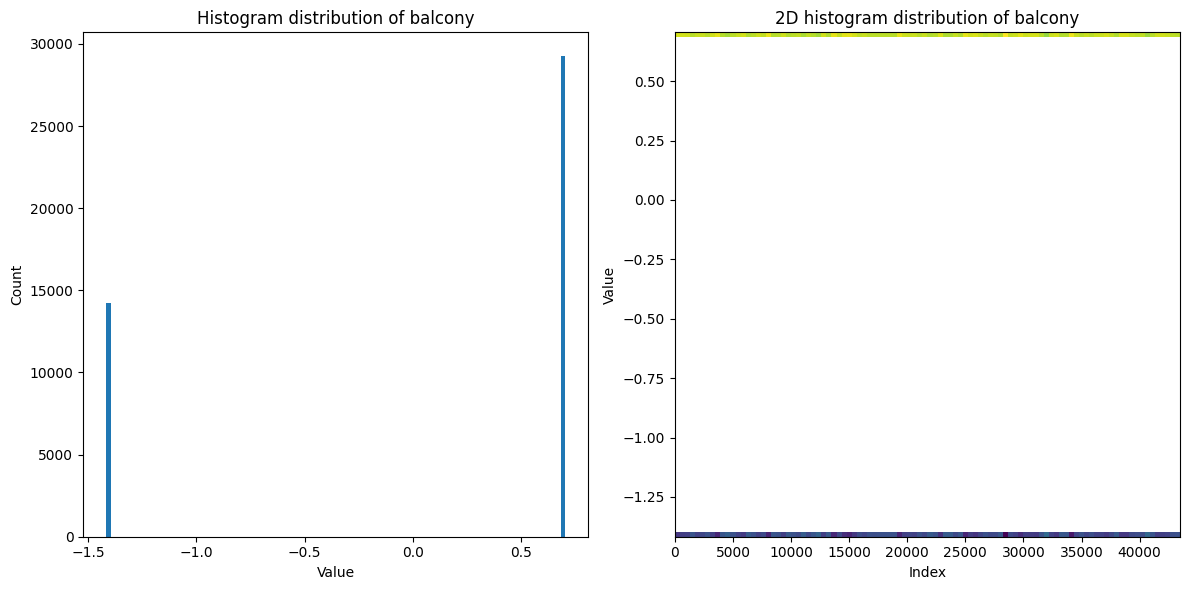

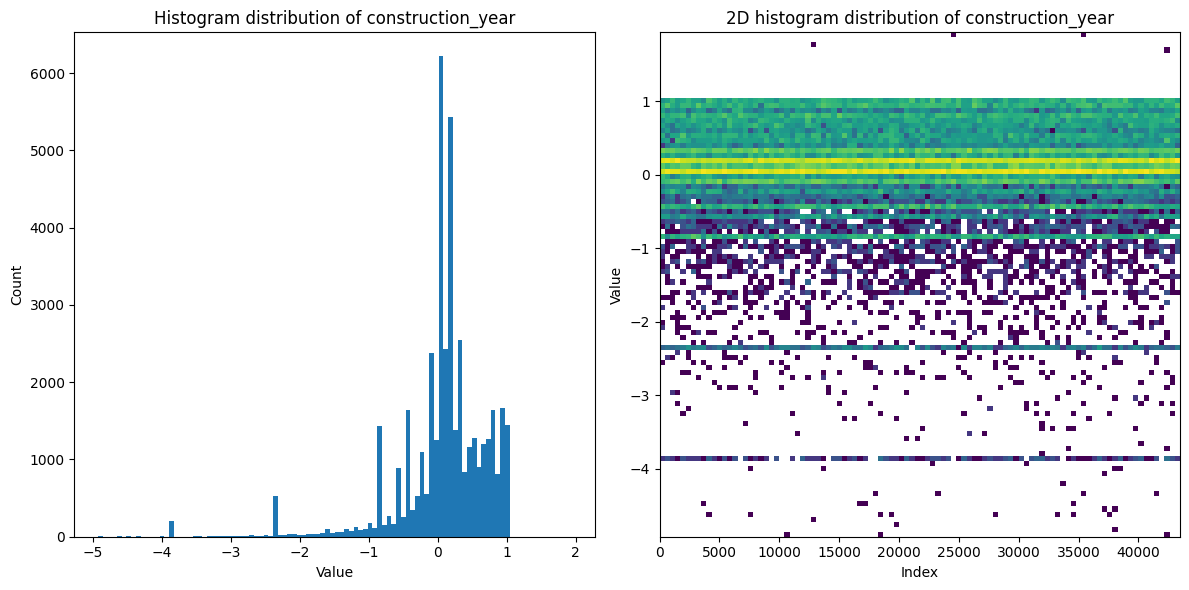

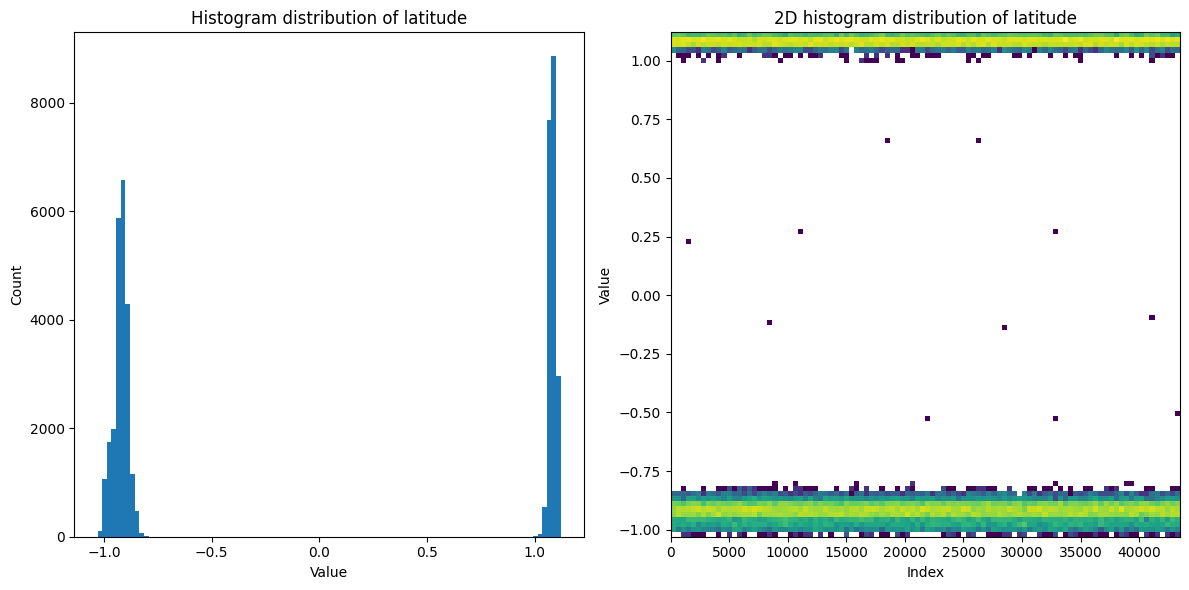

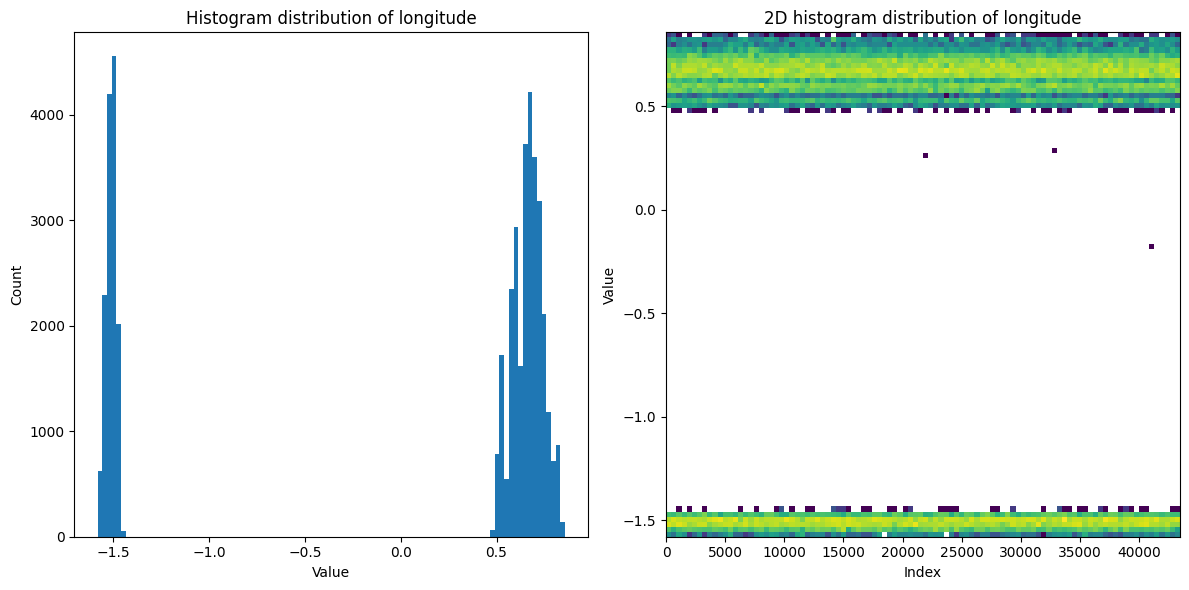

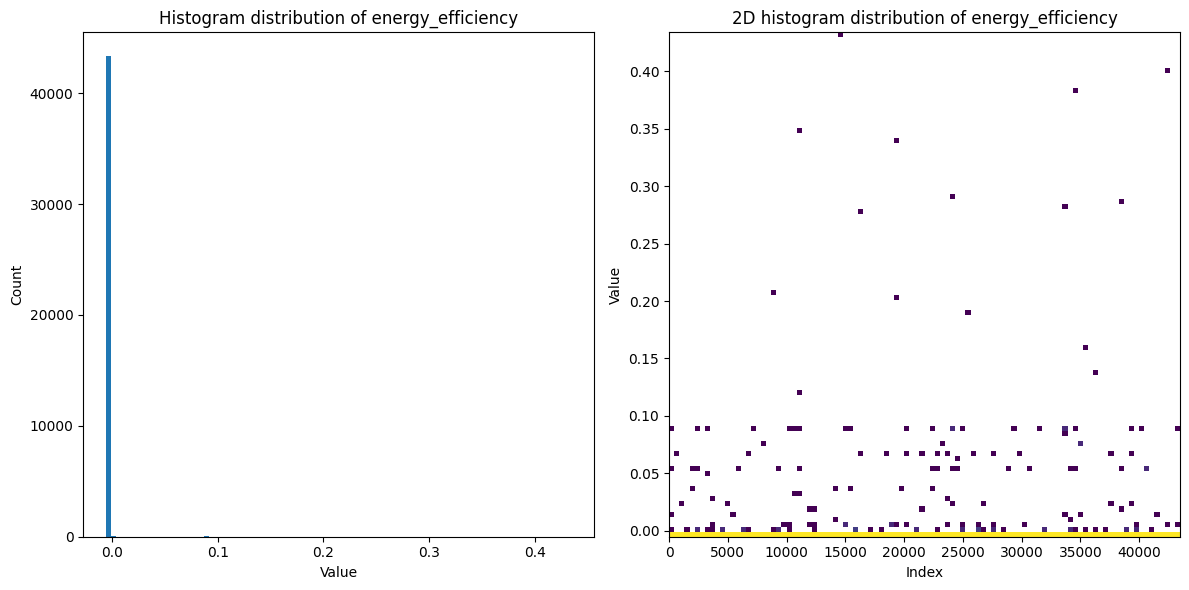

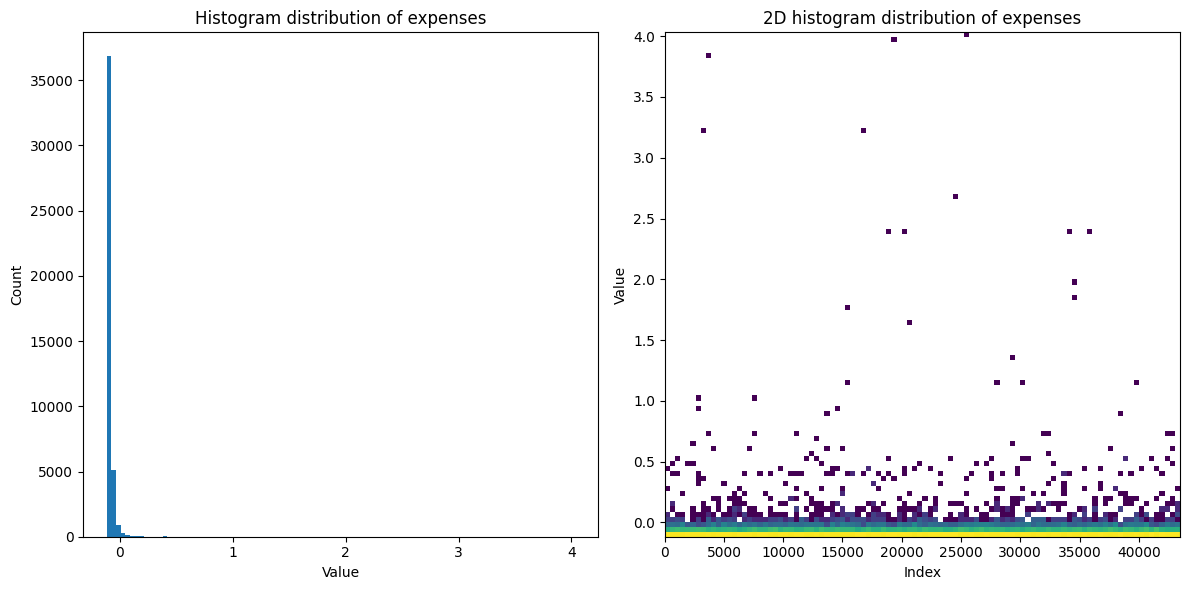

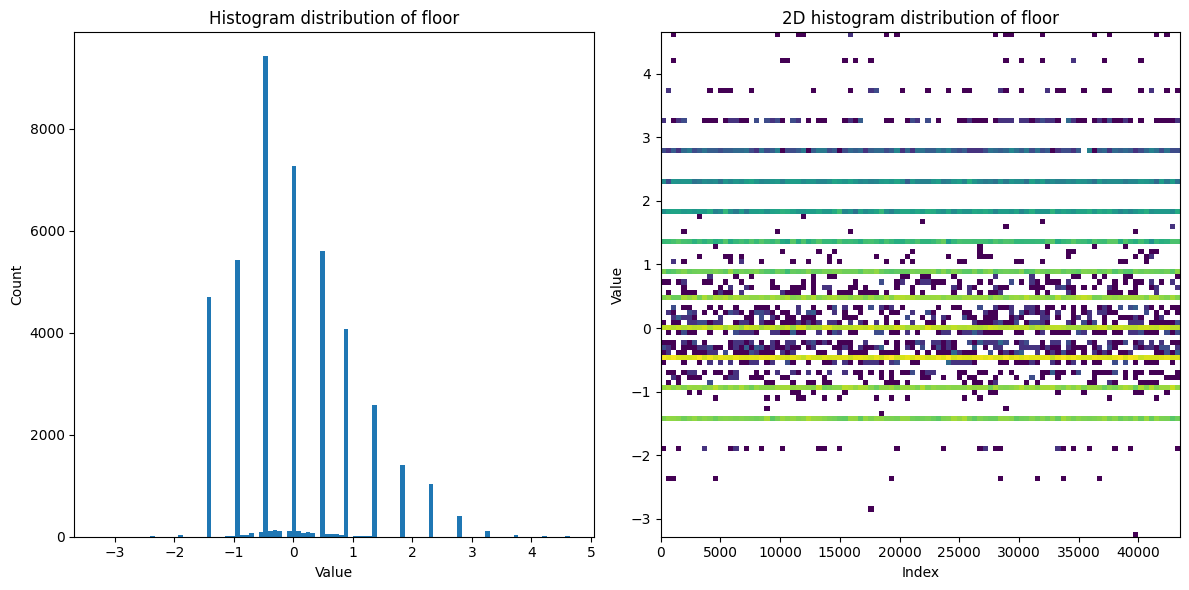

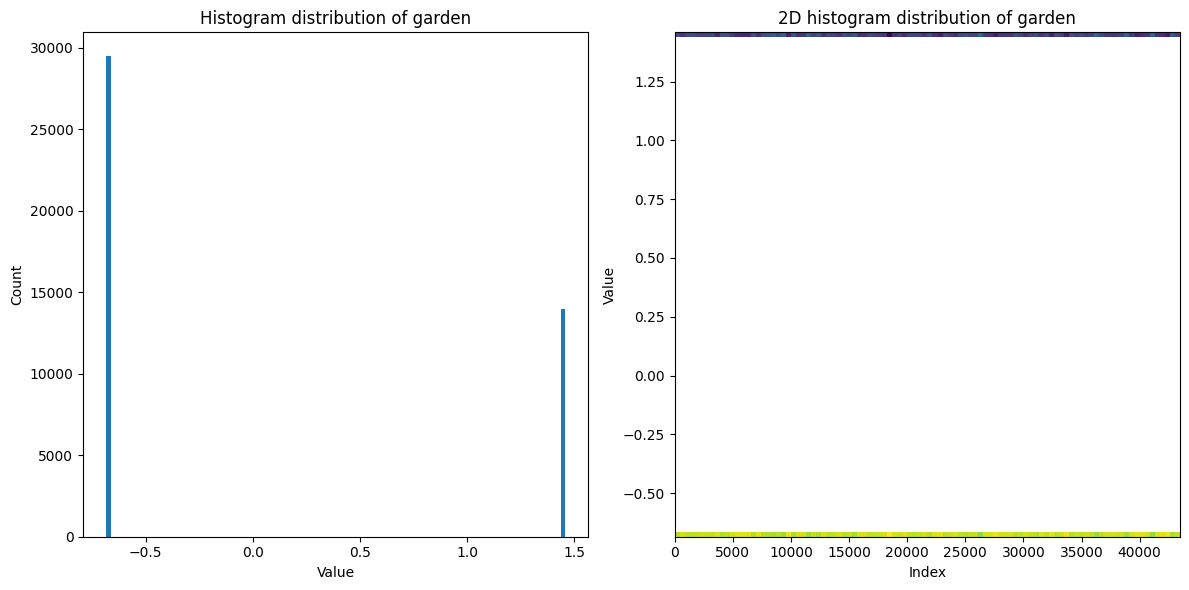

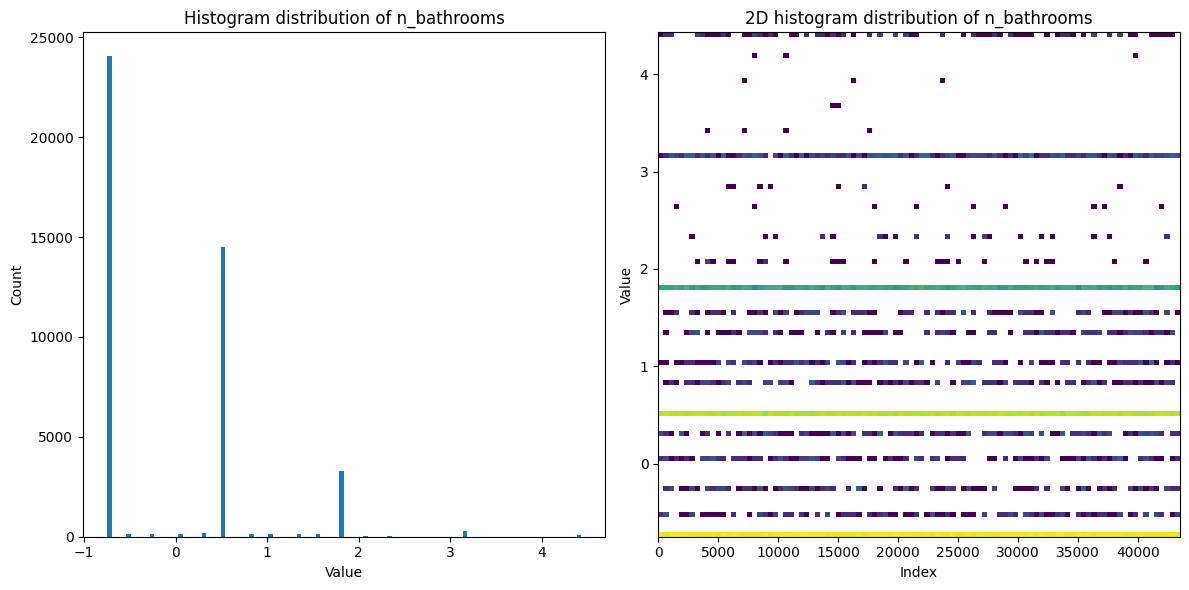

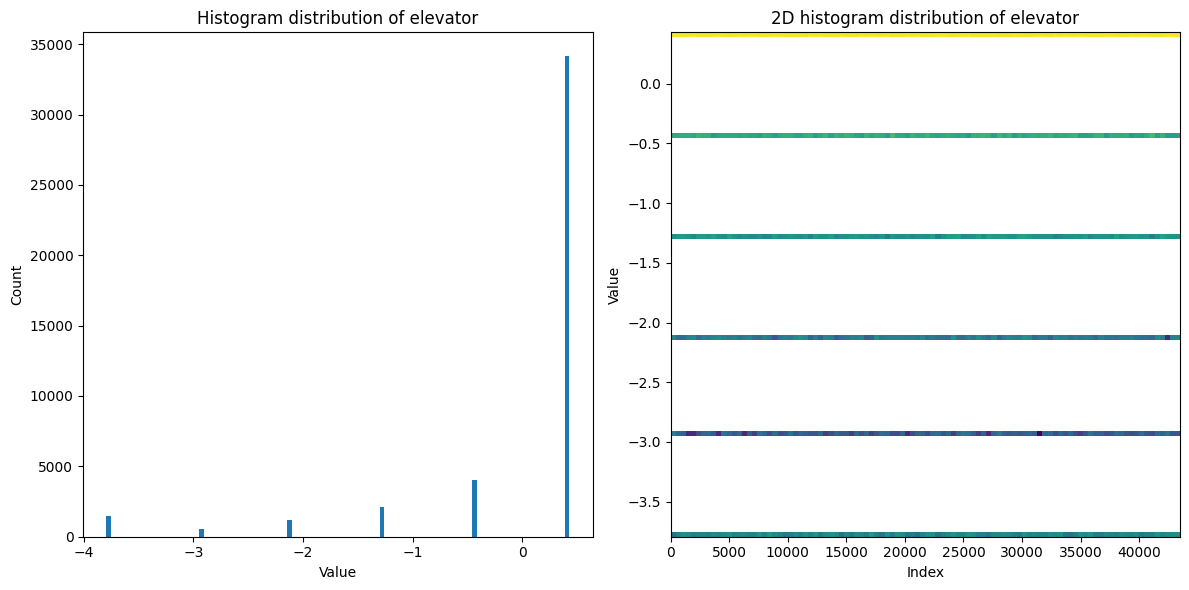

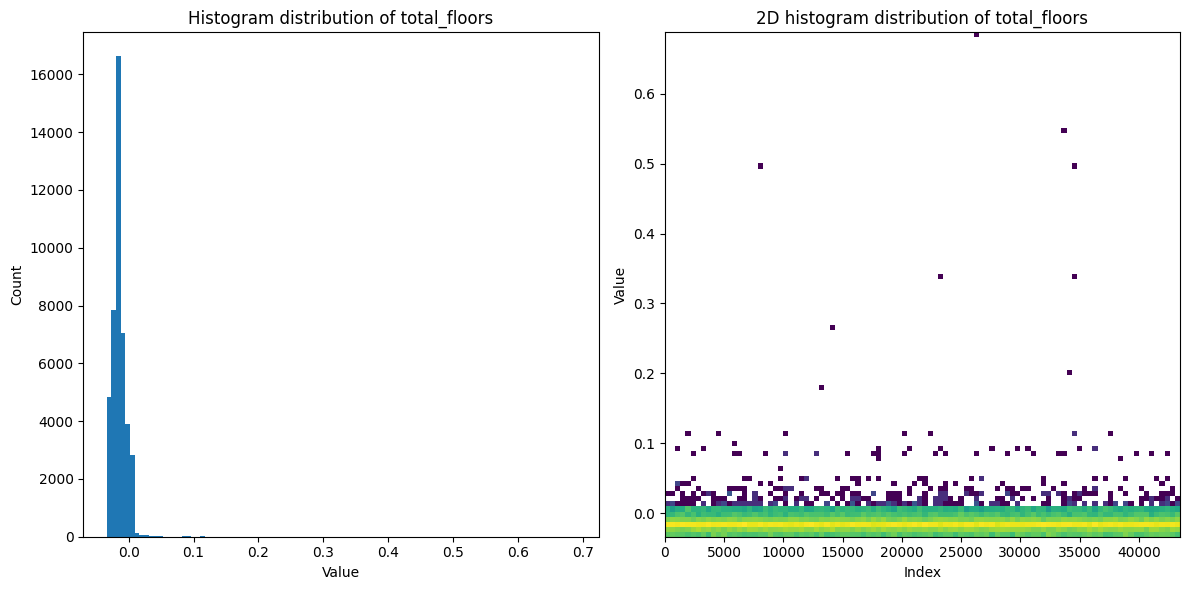

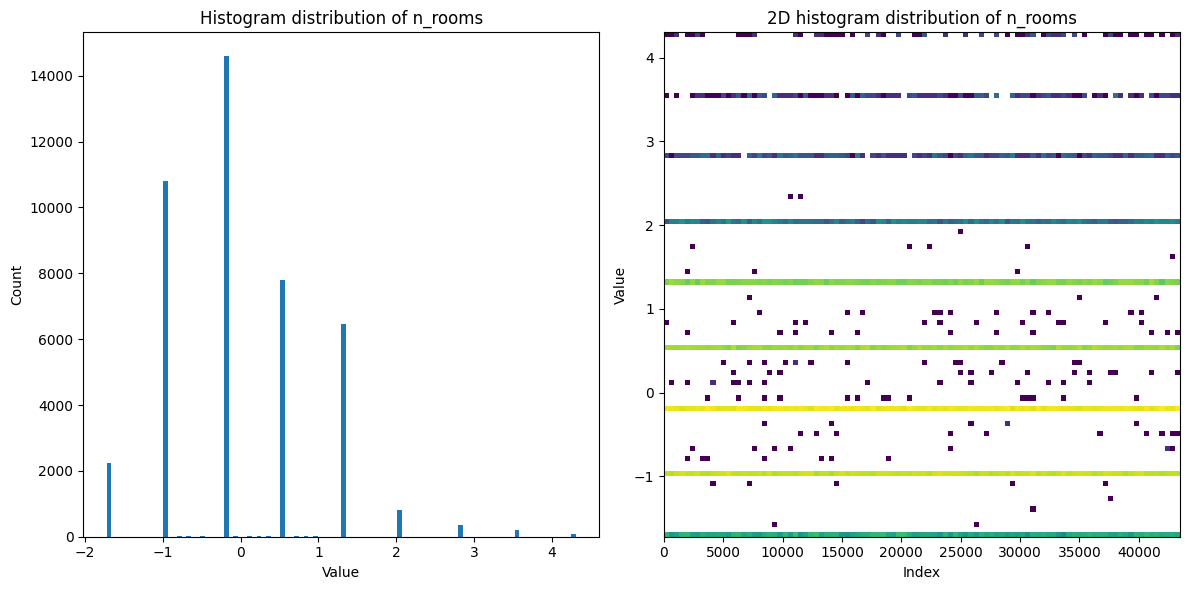

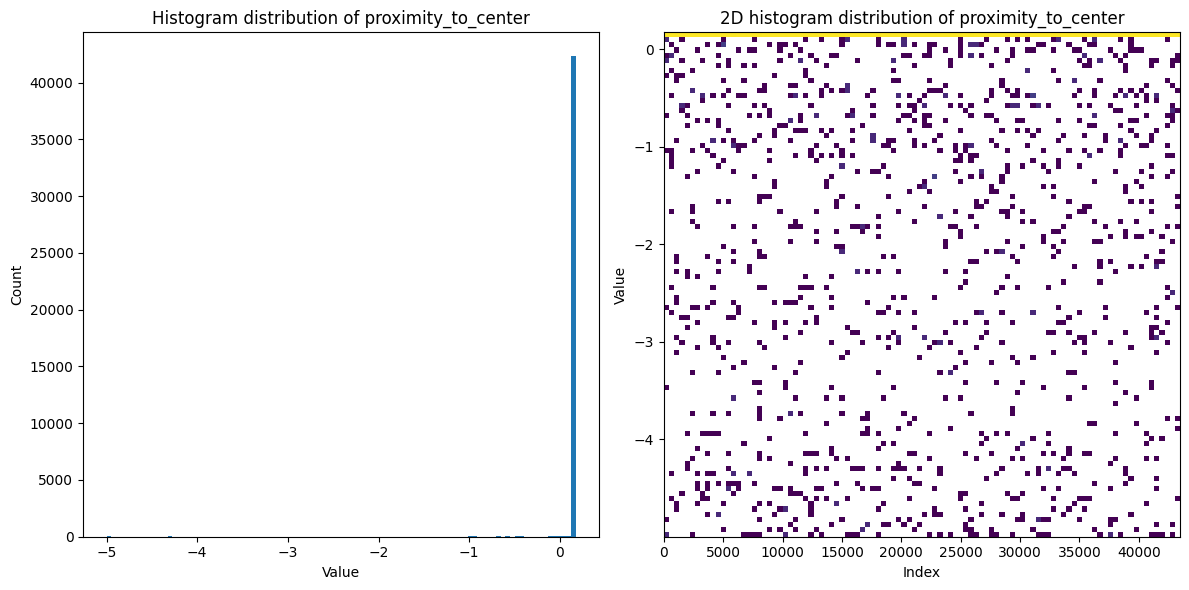

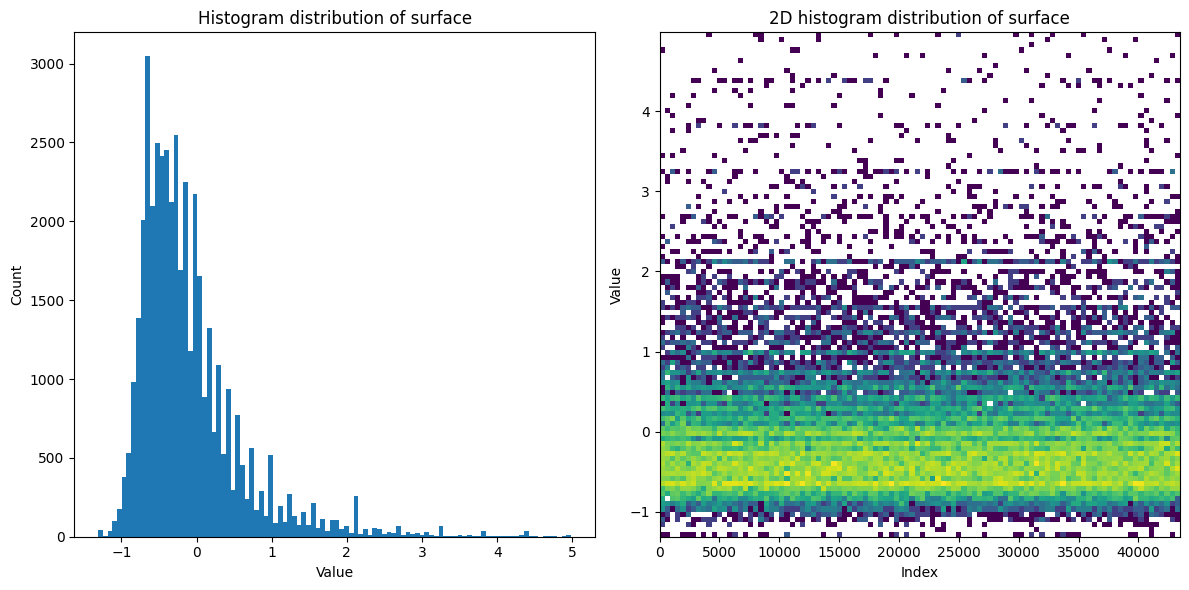

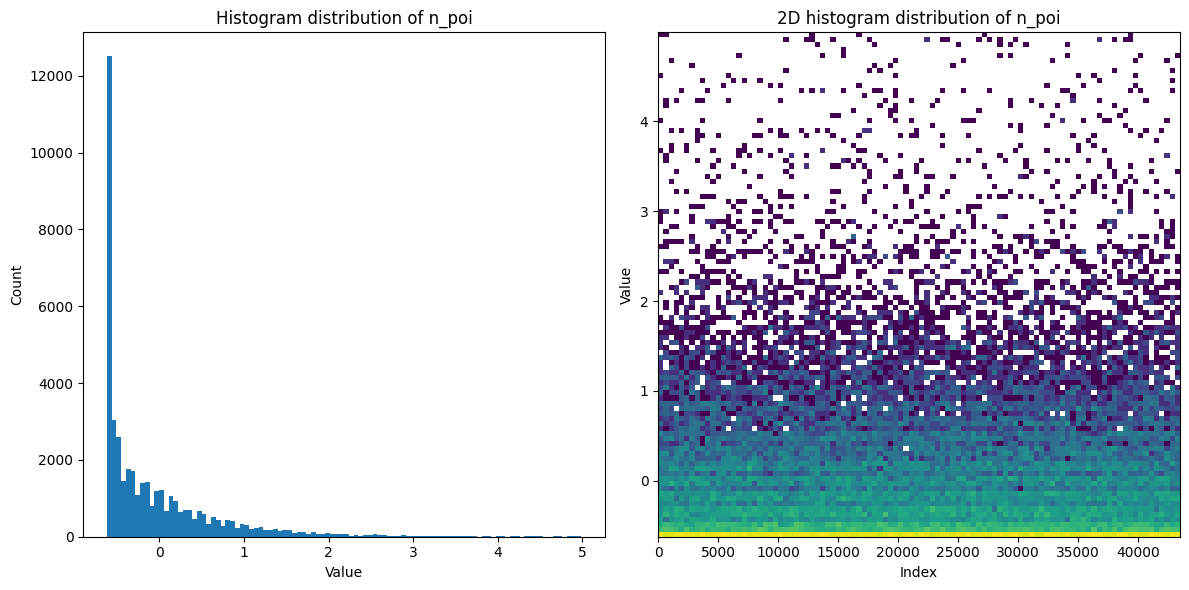

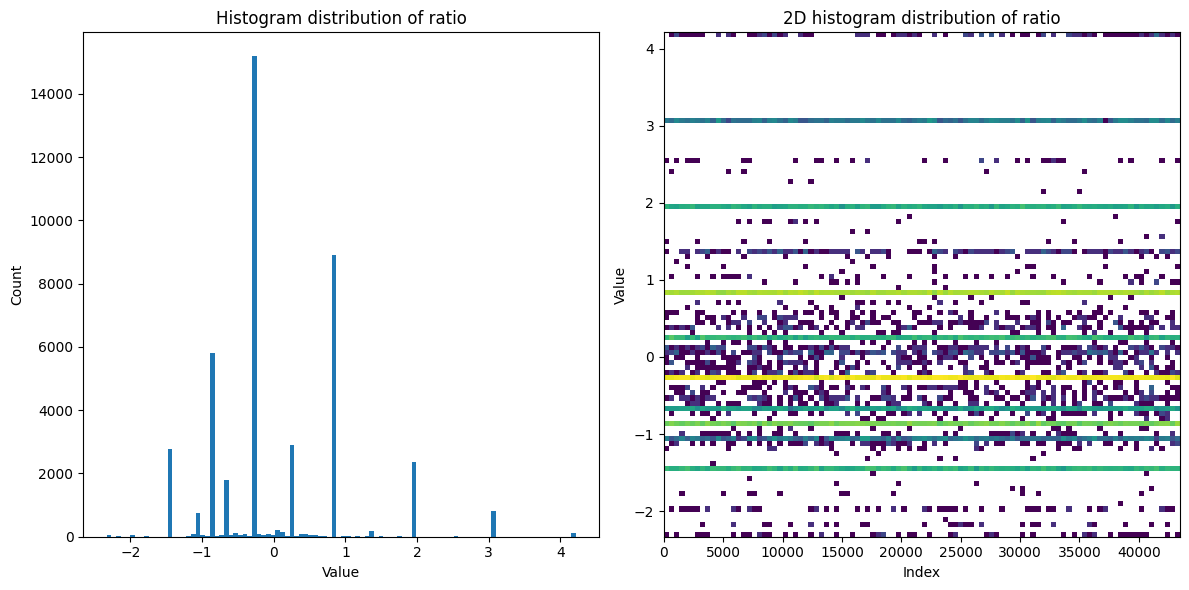

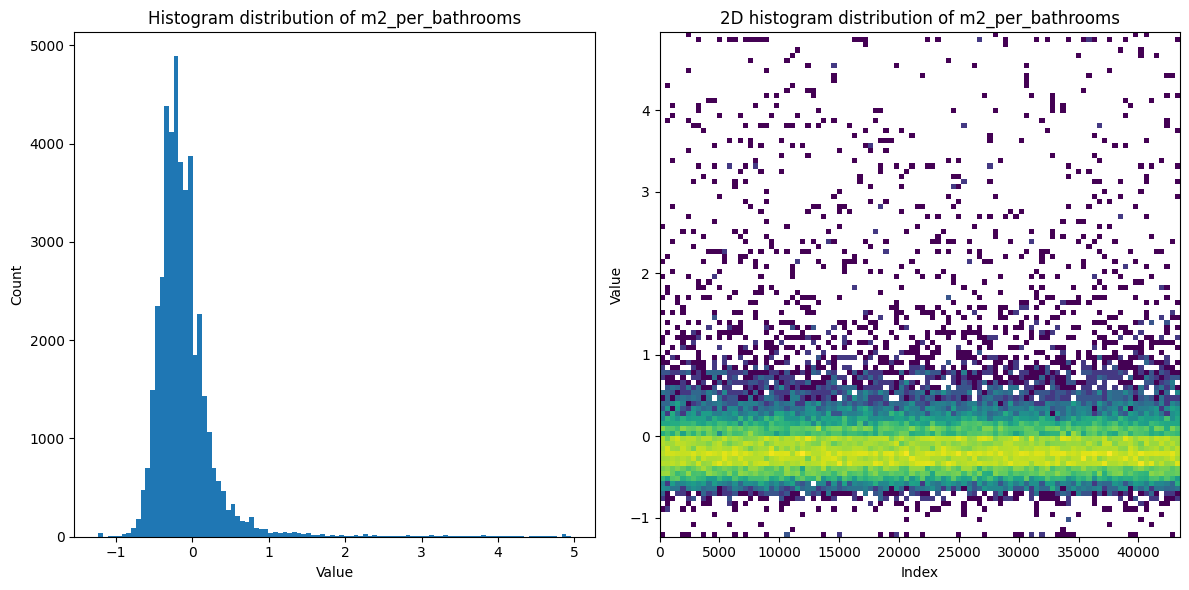

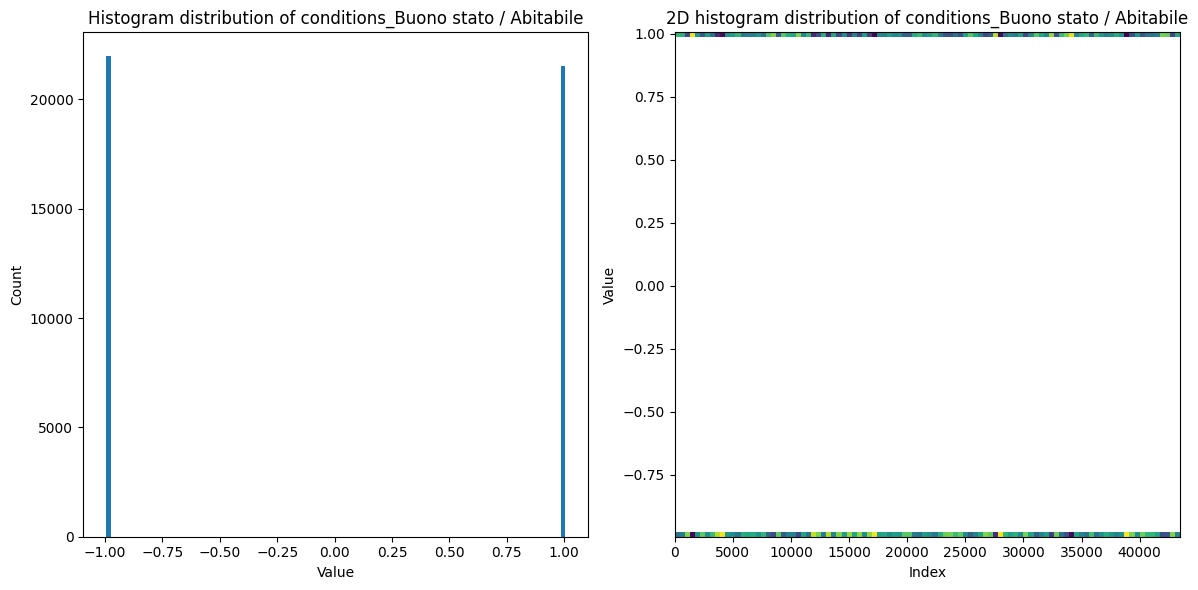

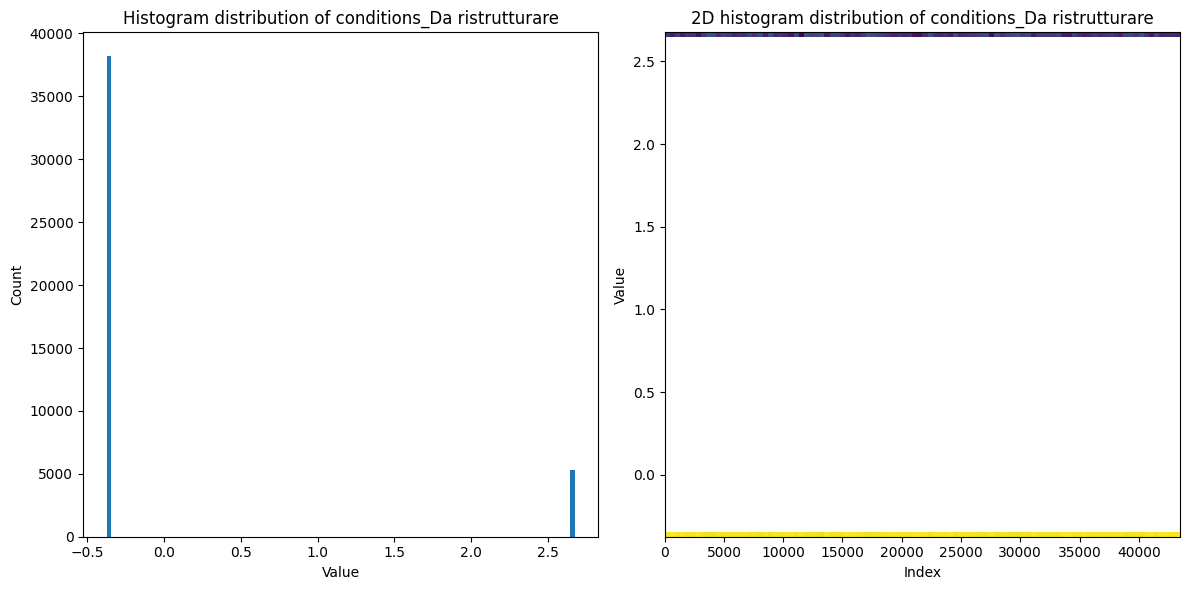

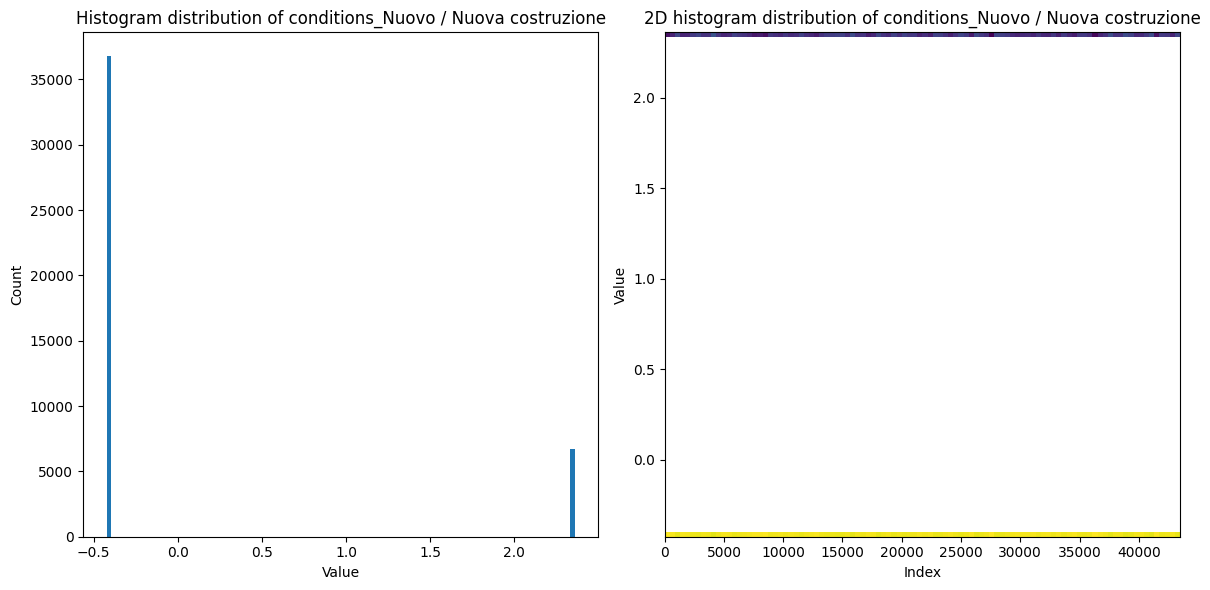

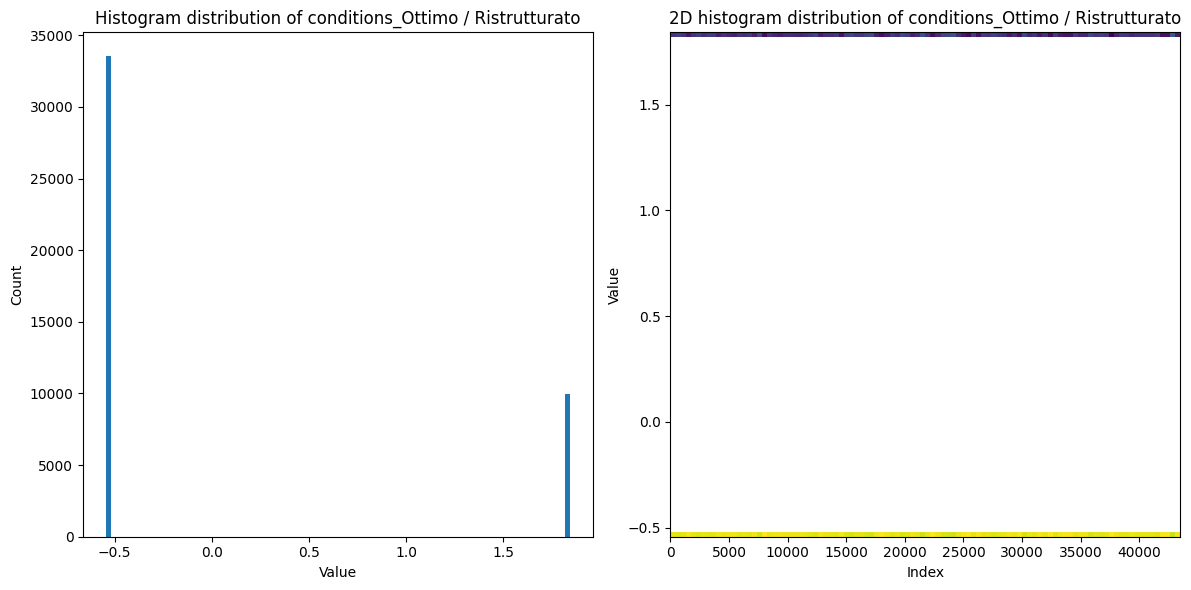

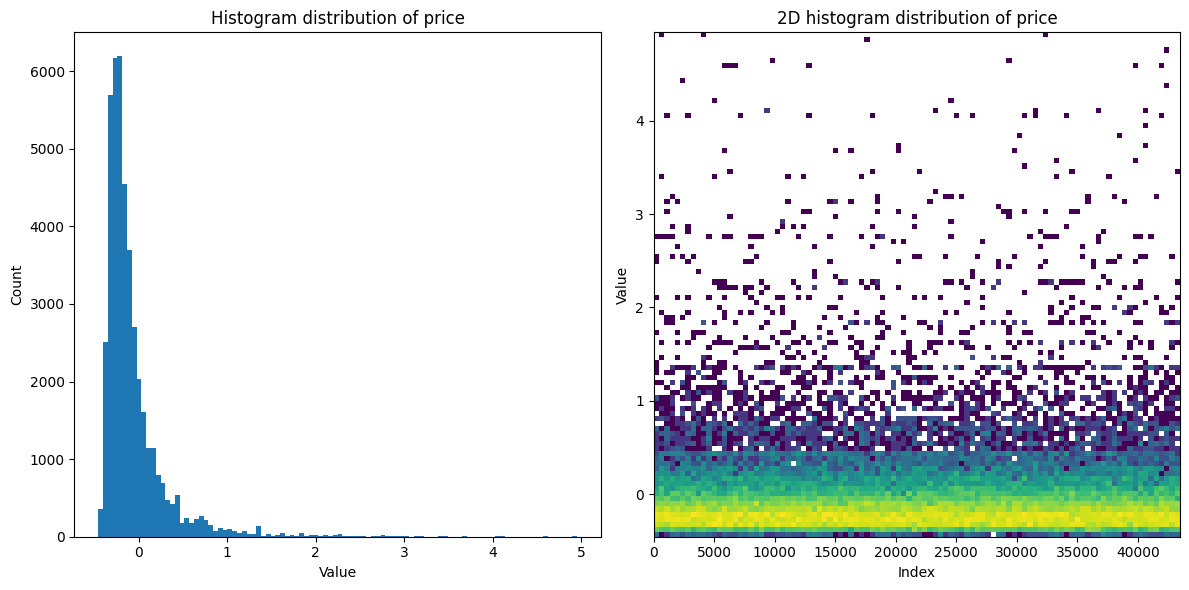

In [50]:
for col in train_df.columns:
    hist_subplot(train_df, col)

# 2.3. Feature Importance Analysis

We plot the heat map which rapresent the correlation between the different features. 

<Axes: >

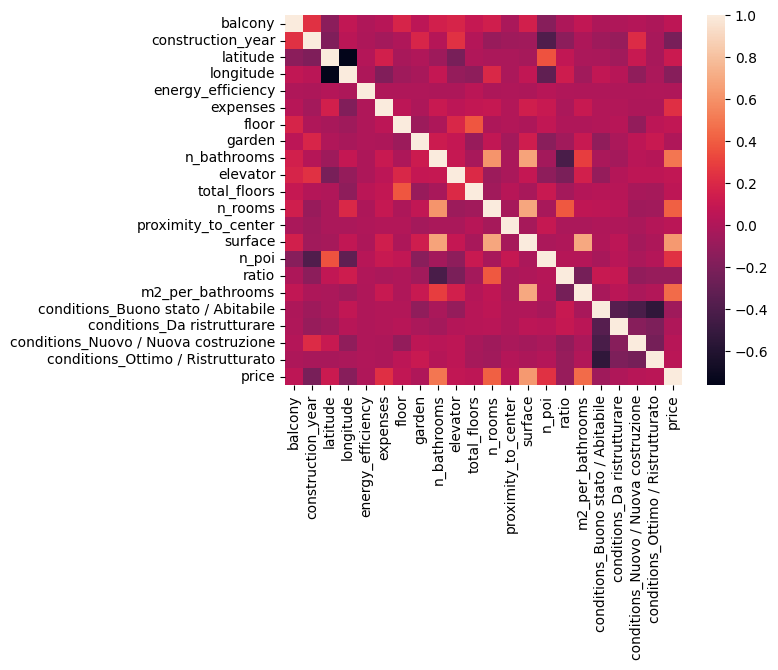

In [51]:
sns.heatmap(train_df.corr())

We perform the feature importance analysis in order to understand how useful the added features by us and each feature is for the trainig of our model.

In [52]:
x_train = train_df.drop('price', axis=1)
y_train = train_df['price']

In [53]:
# compute feature_importances
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(x_train, y_train)
sorted(rf.feature_importances_, reverse=True) #return the feature importances of the random forest model sorted in descending order

[0.4731407992973365,
 0.13238012096574017,
 0.10523309197887991,
 0.07303530717654495,
 0.04474340191579603,
 0.042044781405976735,
 0.024039043677851635,
 0.01743013007520941,
 0.016166499889529607,
 0.015180093249755017,
 0.01514144699403318,
 0.01347410990731373,
 0.0055961438644671745,
 0.0037650892533370914,
 0.0035140569234665964,
 0.0034313163580812576,
 0.003196672670364826,
 0.0030760414208357545,
 0.0027055837087319942,
 0.002386297402236651,
 0.00031997186451181885]

<BarContainer object of 21 artists>

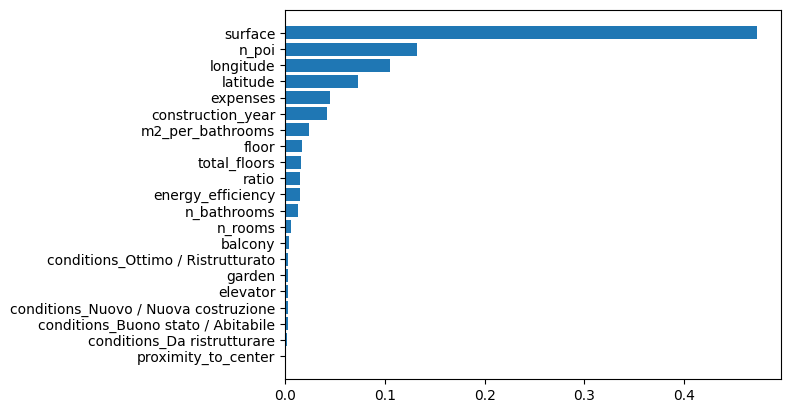

In [54]:
# plot feature_importances
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_train.columns[sorted_idx], rf.feature_importances_[sorted_idx])

# 3. Training

In [55]:
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'MLPRegressor': MLPRegressor(),
    'SVR': SVR()
}

In [56]:
for model_name, model in models.items(): #loop on the previously created dictionary with the different models 
    print('model: {}'.format(model_name))
    model.fit(x_train, y_train) #train all the models in the dictionary

model: LinearRegression
model: RandomForestRegressor
model: GradientBoostingRegressor
model: KNeighborsRegressor
model: DecisionTreeRegressor
model: MLPRegressor
model: SVR


# 4. Evaluation

We create this function in order to test the performance of our models using the train data, it will not be as accurate as with the test data but at least it can give us an approximate idea if the model fits well (this choice is done given the modality of the challenge, we do not have the price of the test data and we have only 5 submission on kaggle, this is an alternative to still see the performance of our model). 
We visualize the efficiency of the model thanks to the scatter plot, the diagonal line in the plot represents the perfect prediction line. If the points are distributed around the diagonal line, it indicates that the model is performing well.

In [57]:
def evaluate_model(model, x, y, y_scaler, scoring='neg_mean_squared_error'):
    scores = cross_val_score(model, x, y, cv=5, scoring=scoring, n_jobs=-1) #perform a 5-fold cross-validation with the specified scoring metric
    y_pred = cross_val_predict(model, x, y, cv=5, n_jobs=-1)
    print('scores: {}'.format(scores))
    print('mean: {}'.format(-scores.mean()))
    print('std: {}'.format(scores.std()))
    # plot scatter plot of y_pred vs y_true
    y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1)) #predicted target data is transformed back to its original scale using the target scaler
    y = y_scaler.inverse_transform(y.values.reshape(-1, 1)) #same for the true target data
    plt.scatter(y, y_pred) 
    plt.plot([0, max(y.max(), y_pred.max())], [0, max(y.max(), y_pred.max())], 'r--', lw=2) #diagonal line that rapresent the perfect prediction line 
    plt.title('{}'.format(model))
    plt.xlabel('y_true')
    plt.ylabel('y_pred')
    plt.show()
    plt.close()
    return scores

Then for each model we calculate the MSE mean and standard deviation and store them in increasing order in a table, in this way the first model will be the best one among the other to describe our data. 

In [58]:
performance = {model_name: {'MSE_mean': 0.0, 'MSE_std': 0.0} for model_name in models.keys()}

model: LinearRegression
scores: [-0.08120518 -0.06661579 -0.06936283 -0.07313481 -0.06861917]
mean: 0.07178755480906124
std: 0.005160850299091427


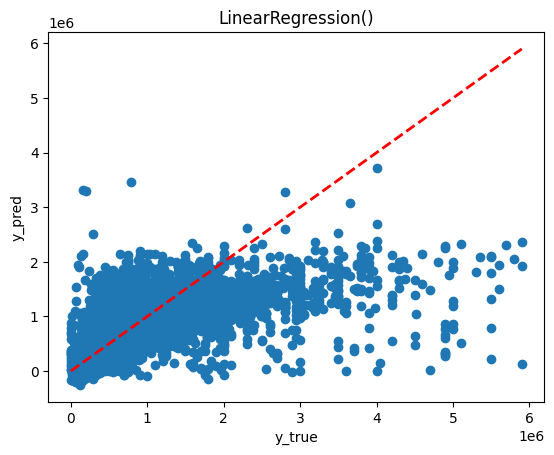

model: RandomForestRegressor
scores: [-0.04164049 -0.03047985 -0.03378131 -0.03736017 -0.03251382]
mean: 0.03515513084822519
std: 0.003940665470227165


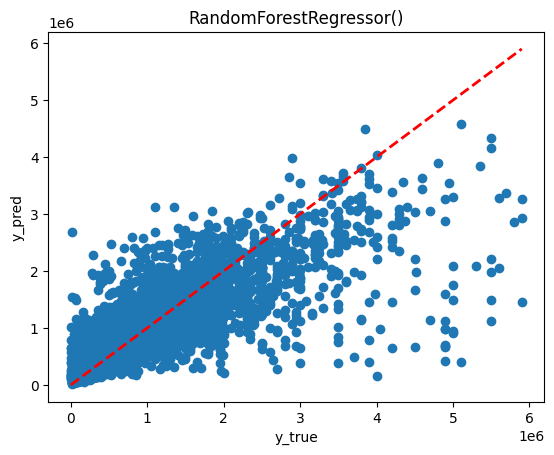

model: GradientBoostingRegressor
scores: [-0.05093022 -0.03763217 -0.0424684  -0.04514209 -0.04032171]
mean: 0.04329891617495917
std: 0.004545318327248541


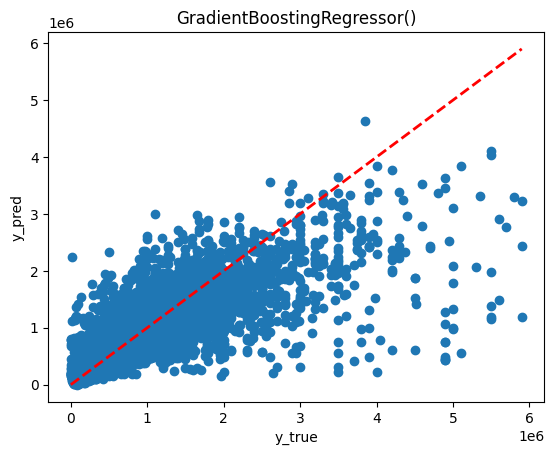

model: KNeighborsRegressor
scores: [-0.07541666 -0.06012561 -0.06326917 -0.06766768 -0.06121161]
mean: 0.06553814611691192
std: 0.005572840176311252


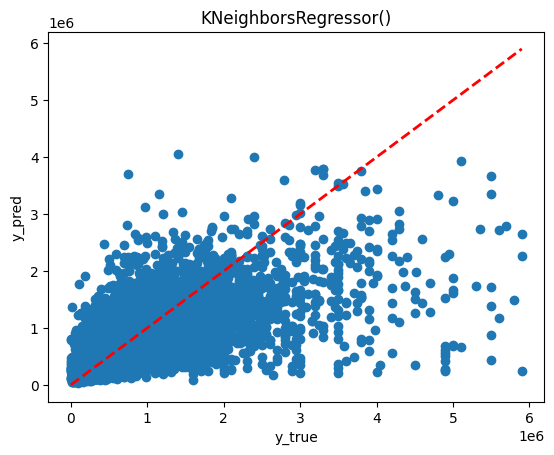

model: DecisionTreeRegressor
scores: [-0.07618983 -0.06473076 -0.06919895 -0.07056527 -0.07406298]
mean: 0.07094955917976152
std: 0.0039759181924769104


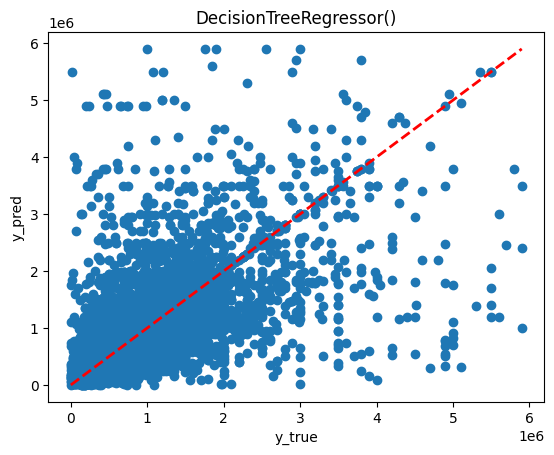

model: MLPRegressor
scores: [-0.0617617  -0.04710372 -0.05194516 -0.05450539 -0.05076317]
mean: 0.0532158292680293
std: 0.004892502837532175


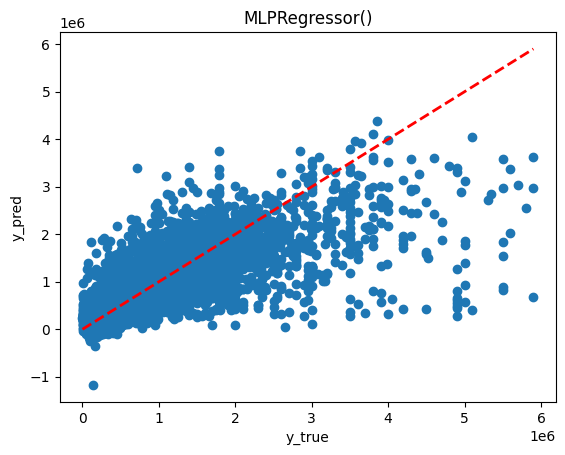

model: SVR
scores: [-0.06283276 -0.04729666 -0.04996367 -0.05559404 -0.05082154]
mean: 0.053301733212833845
std: 0.00546717443156489


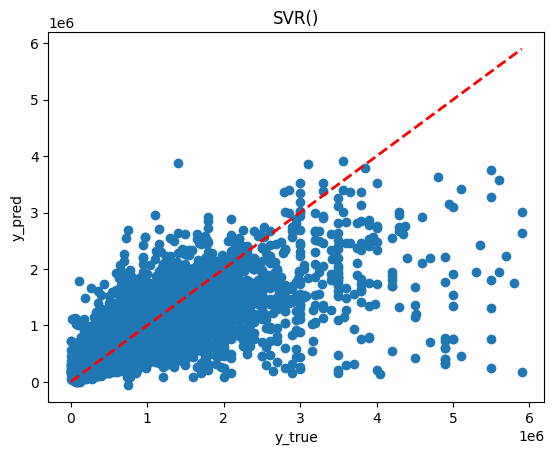

In [59]:
for model_name, model in models.items():
    print('model: {}'.format(model_name))
    MSE_scores = evaluate_model(model, x_train, y_train, y_scaler, scoring='neg_mean_squared_error')
    performance[model_name]['MSE_mean'] = -MSE_scores.mean()
    performance[model_name]['MSE_std'] = MSE_scores.std()

In [60]:
performance_df = pd.DataFrame.from_dict(performance, orient='index').sort_values(by='MSE_mean').reset_index().rename(columns={'index': 'model'})
performance_df

,model,MSE_mean,MSE_std
0,RandomForestRegressor,0.035155,0.003941
1,GradientBoostingRegressor,0.043299,0.004545
2,MLPRegressor,0.053216,0.004893
3,SVR,0.053302,0.005467
4,KNeighborsRegressor,0.065538,0.005573
5,DecisionTreeRegressor,0.070950,0.003976
6,LinearRegression,0.071788,0.005161


# 5. Submission

We preprocess the test data. 

In [61]:
def x_test_preprocessing(x_test, poi_df, x_imputer, x_scaler):
    x_test['n_poi'] = x_test.apply(lambda x: get_n_poi(x['latitude'], x['longitude'], poi_df), axis=1) #add the feature n_poi
    x_test['ratio'] = x_test.apply(lambda x: lambda_ratio(x), axis=1) #add the feature ratio
    x_test['m2_per_bathrooms'] = x_test.apply(lambda x: lambda_m2_per_bathrooms(x), axis=1) #add the feature m2_per_bathrooms
    x_test['garden'] = x_test['garden'].fillna(False) #fill missing value in garden and balcony with False
    x_test['balcony'] = x_test['balcony'].fillna(False)
    x_test['conditions'] = x_test['conditions'].fillna('Buono stato / Abitabile') #fill NaNs with the most frequent categorical value
    x_test = pd.get_dummies(x_test) #create dummy values for the categorical values of conditions
    for col in x_test.columns:
        if x_test[col].dtype == 'bool':
            x_test[col] = x_test[col].astype('int64') #convert boolean values into integers numbers 
    x_test = pd.DataFrame(x_imputer.transform(x_test), columns=x_test.columns) #fill in missing values for any remaining missing values in the test data set using an imputer object x_imputer
    x_test = pd.DataFrame(x_scaler.transform(x_test), columns=x_test.columns) #scales the features
    return x_test

In [62]:
test_id = test_df['id'] #extract the id column from the test_df data frame and saves it to test_id
x_test = test_df.drop('id', axis=1) #drop the id column from x_test
x_test = x_test_preprocessing(x_test, poi_df, x_imputer, x_scaler) #apply the x_test_preprocessing function to preprocess the test data set in the same way as the train set 

This last line of code ensure that the model is generalizable and performs well on unseen data.

We creeate csv file for the submission. 

In [63]:
def submission(model, filename, x_test, y_scaler):
    y_pred = y_scaler.inverse_transform(model.predict(x_test).reshape(-1, 1)) #use the model to predict the target values for the preprocessed test data and inverse transforms to their original unit the predicted values (which have been previously scaled)
    y_pred = pd.DataFrame(y_pred, columns=['price'])
    submission_df = pd.concat([test_id, y_pred], axis=1) #combynes test_id and y_pred 
    submission_df.to_csv(filename, index=False) #save the resulting dataframe to a csv file, the index=False is to avoid writing the index columns
    return

In [64]:
for model_name, model in models.items():
    submission(model, 'submission/{}.csv'.format(model_name), x_test, y_scaler)

We create a for loop in order to create a csv file for each model trained in the previous subsection. 

# 6. Tuning

We find the best combination of hyperparameters for the best model we have obtained so far

We now use grid search to tune the hyperparameters for the random forest regression model (which was the model performing better).

In [65]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 5, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'bootstrap': [True, False]
} # dictionary that specifies a range of values to try for different hyperparameters 
rf = RandomForestRegressor(random_state=42, n_jobs=-1) #jobs set to -1 to use all available processors for parallel computing
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=2) #perform grid search 
grid_search.fit(x_train, y_train) #train and evaluate  the model using different combinations of hyperparameters and cross-validation folds, and returns the best combination of hyperparameters 

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=50; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=50; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=log2, n_estimators=50; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=log2, n_estimators=50; total time=   4.4s
[CV] END bootstrap=True, max_depth=None, max_features=log2, n_estimators=50; total time=   5.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=50; total time=   5.8s
[CV] END bootstrap=True, max_depth=None, max_features=log2, n_estimators=100; total time=   8.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   8.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   8.7s
[CV] END bootstrap=True, max_depth=None, max_features=log2, n_estimator

/home/vincenzo/.anaconda3/envs/stable/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, n_estimators=150; total time=  13.7s
[CV] END bootstrap=False, max_depth=None, max_features=None, n_estimators=50; total time=  18.0s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, n_estimators=150; total time=  15.3s
[CV] END bootstrap=False, max_depth=None, max_features=None, n_estimators=50; total time=  18.6s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, n_estimators=150; total time=  15.2s
[CV] END bootstrap=False, max_depth=None, max_features=log2, n_estimators=100; total time=  10.6s
[CV] END bootstrap=False, max_depth=None, max_features=None, n_estimators=50; total time=  19.7s
[CV] END bootstrap=False, max_depth=None, max_features=log2, n_estimators=100; total time=  11.0s
[CV] END bootstrap=False, max_depth=None, max_features=log2, n_estimators=100; total time=  11.5s
[CV] END bootstrap=False, max_depth=5, max_features=None, n_estimators=50; total time=   7.7s
[CV] END bootstrap=False, m

GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [None, 5, 10],
                         'max_features': [None, 'sqrt', 'log2'],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='neg_mean_squared_error', verbose=2)

In [66]:
best_params = grid_search.best_params_
best_params #dictionary of best hyperparameters find during the gridsearch

{'bootstrap': True,
 'max_depth': None,
 'max_features': None,
 'n_estimators': 200}

scores: [-0.04095176 -0.02952135 -0.03327439 -0.0370972  -0.03301691]
mean: 0.03477232233662301
std: 0.003911225611583042


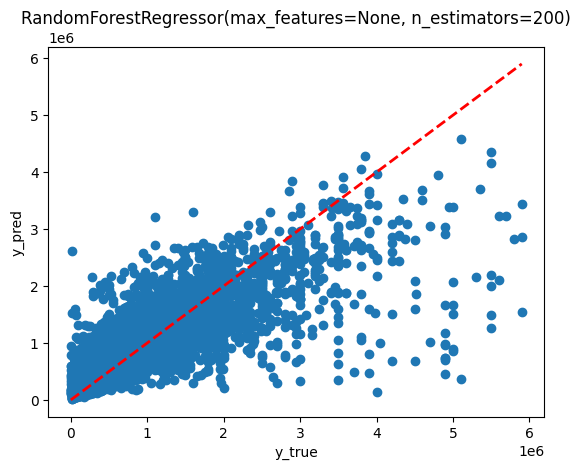

MSE: 0.035 (0.004 std)


In [67]:
tuned_model = RandomForestRegressor(**best_params)
tuned_model.fit(x_train, y_train) #create a new instance of the RandomForestRegressor class with the best hyperparameter 
MSE_score = evaluate_model(tuned_model, x_train, y_train, y_scaler, scoring='neg_mean_squared_error') #evaluate the model on the training data 
print('MSE: {:.3f} ({:.3f} std)'.format(-MSE_score.mean(), MSE_score.std())) #we print the scoring metric: MSE

We print the MSE to compare it to the one found just with the model not tuned and se if there has been an improvement in the effficiency of the model (all this test are doen with the train data for the circumstances explained before in subsection 4 - Evaluation)

We submit the csv file. 

In [68]:
submission(tuned_model, 'submission/tuned_RandomForest.csv', x_test, y_scaler)